In [2]:
import copy
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

pd.set_option('display.max_rows', 100)

## 1. Exploratory analysis

In [80]:
data = pd.read_csv('../data/pbp_data.csv')

In [81]:
data = data[[str(game_id).startswith('222') for game_id in data['game_id']]]
data.tail()

,game_id,date,team_home,team_away,period,event_desc,home_possession_prob,home_team_free_throws,bonus,ejections,time_left,margin,time_pressure,line,home_team_won
1424821,22201230,2023-04-09,POR,GSW,4,field goal (missed),0.3,0,-1,0,27.6,-56,-0.960940,17.0,0
1424822,22201230,2023-04-09,POR,GSW,4,defensive rebound,0.0,0,-1,0,22.6,-56,-0.982773,17.0,0
1424823,22201230,2023-04-09,POR,GSW,4,turnover,1.0,0,-1,0,0.7,-56,-1.000000,17.0,0
1424824,22201230,2023-04-09,POR,GSW,4,last posession of quarter,0.5,0,-1,0,0.0,-56,-1.000000,17.0,0
1424825,22201230,2023-04-09,POR,GSW,4,end period,0.5,0,-1,0,0.0,-56,-1.000000,17.0,0


In [82]:
unique_games = data.groupby('game_id').last().reset_index()
unique_games.head()

,game_id,date,team_home,team_away,period,event_desc,home_possession_prob,home_team_free_throws,bonus,ejections,time_left,margin,time_pressure,line,home_team_won
0,22200001,2022-10-18,BOS,PHI,4,game end,0.5,0,1,0,0.0,9,1.000000,-3.0,1
1,22200002,2022-10-18,GSW,LAL,4,game end,0.5,0,1,0,0.0,14,1.000000,-7.5,1
2,22200003,2022-10-19,DET,ORL,4,game end,0.5,0,0,-1,0.0,4,0.999329,-4.0,1
3,22200004,2022-10-19,IND,WAS,4,game end,0.5,0,0,0,0.0,-7,-0.999998,2.5,0
4,22200005,2022-10-19,ATL,HOU,4,game end,0.5,0,0,0,0.0,10,1.000000,-10.5,1


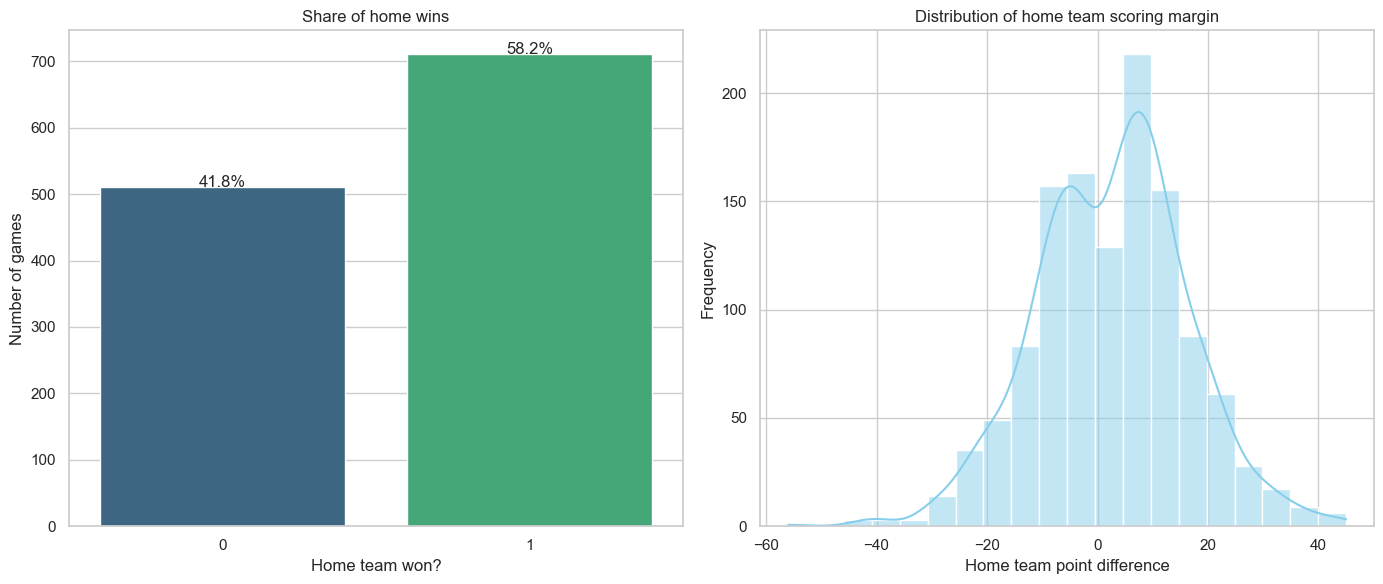

In [83]:
fig, axes = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
sns.countplot(data=unique_games, x="home_team_won", ax=axes[0], palette="viridis")
sns.histplot(unique_games['margin'], kde=True, bins=20, ax=axes[1], color='skyblue')
axes[0].set_title("Share of home wins")
axes[0].set_xlabel("Home team won?")
axes[0].set_ylabel("Number of games")
axes[1].set_xlabel("Home team point difference")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of home team scoring margin")

total = len(unique_games)
for p in axes[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.5
    axes[0].annotate(percentage, (x, y), ha='center')

plt.tight_layout()
plt.show()

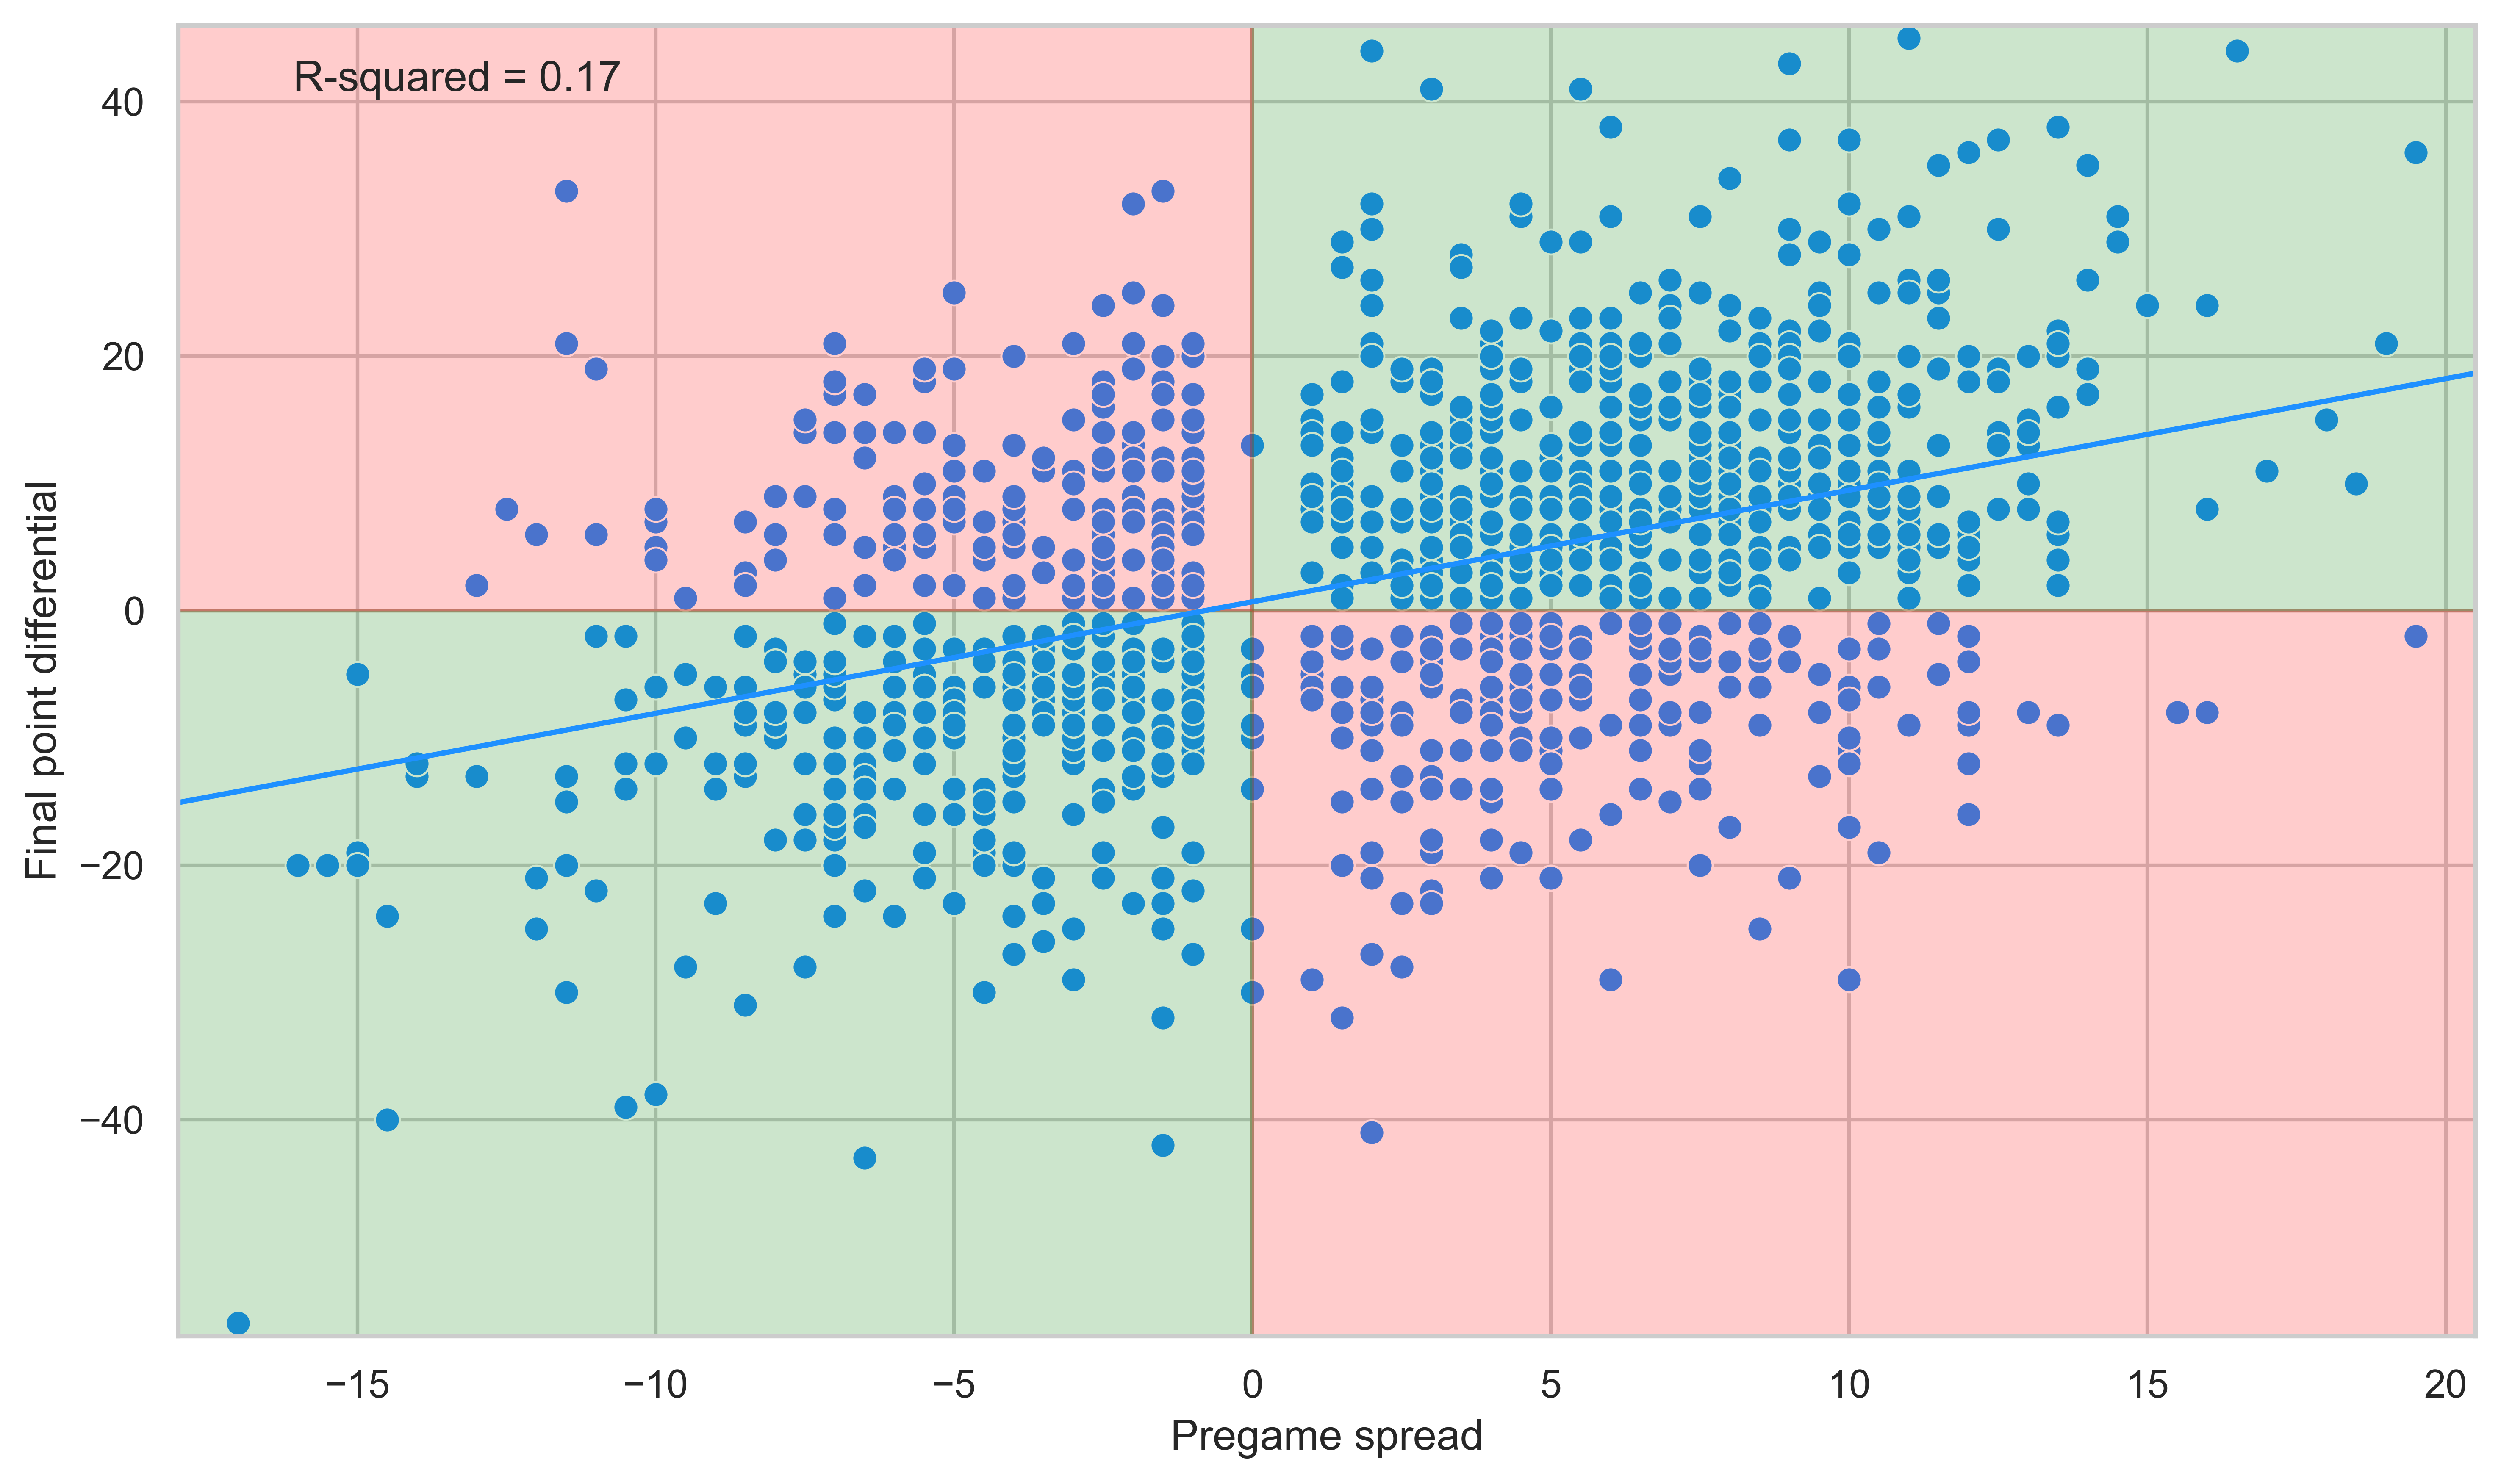

In [86]:
unique_games['favored_team_won'] = (((unique_games['margin'] > 0) & (unique_games['line'] < 0)) | ((unique_games['margin'] < 0) & (unique_games['line'] > 0))).astype(int)
x = - unique_games['line']
y = unique_games['margin']
slope, intercept = np.polyfit(x, y, 1)
r_squared = np.corrcoef(x, y)[0, 1] ** 2

fig, ax = plt.subplots(figsize=(10,6), dpi=600)
sns.scatterplot(x=x, y=y, s=50, ax=ax, color='dodgerblue')
x_dummy = np.linspace(-25, 25)
sns.lineplot(x=x_dummy, y=intercept+slope*x_dummy, ax=ax, color='dodgerblue')
ax.set_xlabel("Pregame spread")
ax.set_ylabel("Final point differential")
ax.set_xlim(x.min()-1,x.max()+1)
ax.set_ylim(y.min()-1,y.max()+1)

quarters = [
    Rectangle(xy=(0,0), width=x.max()+1, height=y.max()+1, color='green', alpha=0.2),  # First quarter
    Rectangle(xy=(0,y.min()-1), width=x.max()+1, height=-y.min()+1, color='red', alpha=0.2),
    Rectangle(xy=(x.min()-1,y.min()-1), width=-x.min()+1, height=-y.min()+1, color='green', alpha=0.2),
    Rectangle(xy=(x.min()-1, 0), width=-x.min()+1, height=y.max()+1, color='red', alpha=0.2),
]

for quarter in quarters:
    ax.add_patch(quarter)

ax.annotate(f'R-squared = {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.tight_layout()
plt.show()
fig.savefig('../figures/figure1.png')

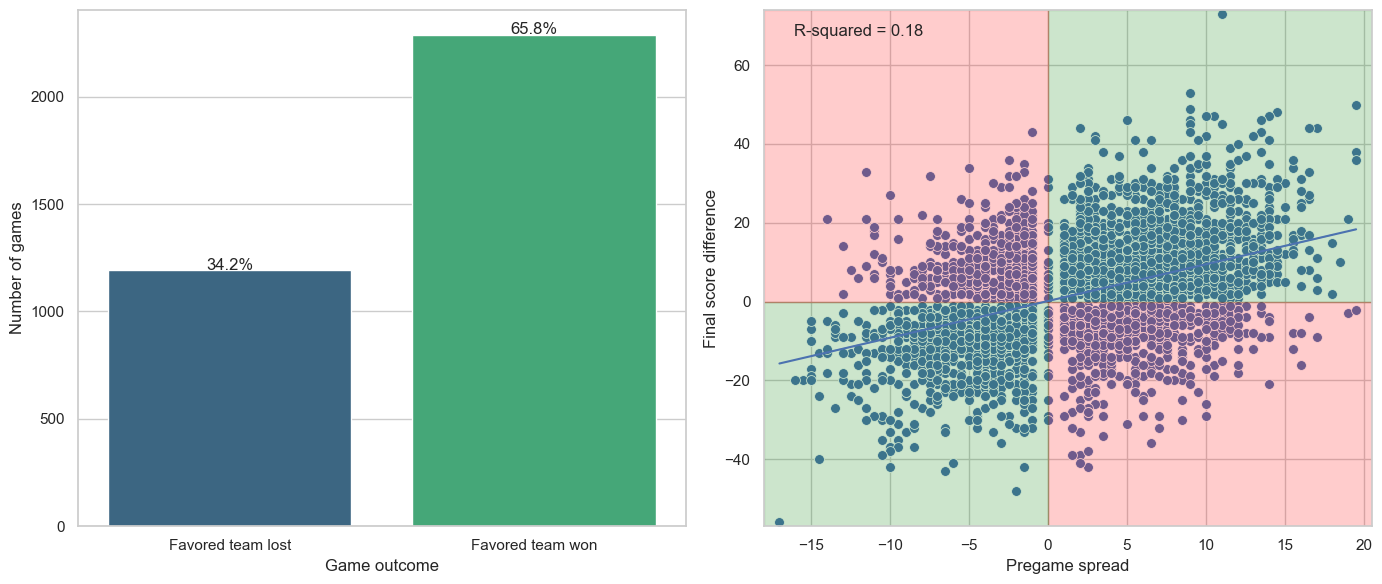

In [36]:
unique_games['favored_team_won'] = (((unique_games['margin'] > 0) & (unique_games['line'] < 0)) | ((unique_games['margin'] < 0) & (unique_games['line'] > 0))).astype(int)
x = - unique_games['line']
y = unique_games['margin']
slope, intercept = np.polyfit(x, y, 1)
r_squared = np.corrcoef(x, y)[0, 1] ** 2

fig, axes = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
sns.countplot(data=unique_games, x="favored_team_won", ax=axes[0], palette="viridis")
sns.scatterplot(x=x, y=y, s=50, ax=axes[1])
sns.lineplot(x=x, y=intercept+slope*x, ax=axes[1])

axes[0].set_xlabel("Game outcome")
axes[0].set_ylabel("Number of games")
axes[0].set_xticklabels(['Favored team lost','Favored team won'])
axes[1].set_xlabel("Pregame spread")
axes[1].set_ylabel("Final score difference")
axes[1].set_xlim(x.min()-1,x.max()+1)
axes[1].set_ylim(y.min()-1,y.max()+1)

quarters = [
    Rectangle(xy=(0,0), width=x.max()+1, height=y.max()+1, color='green', alpha=0.2),  # First quarter
    Rectangle(xy=(0,y.min()-1), width=x.max()+1, height=-y.min()+1, color='red', alpha=0.2),
    Rectangle(xy=(x.min()-1,y.min()-1), width=-x.min()+1, height=-y.min()+1, color='green', alpha=0.2),
    Rectangle(xy=(x.min()-1, 0), width=-x.min()+1, height=y.max()+1, color='red', alpha=0.2),
]

for quarter in quarters:
    axes[1].add_patch(quarter)


total = len(unique_games)
for p in axes[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.5
    axes[0].annotate(percentage, (x, y), ha='center')
axes[1].annotate(f'R-squared = {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
unique_games['abs_line'] = unique_games['line'].abs()
unique_games['abs_line_bins'] = pd.cut(unique_games['abs_line'], bins=np.linspace(0,20,11))

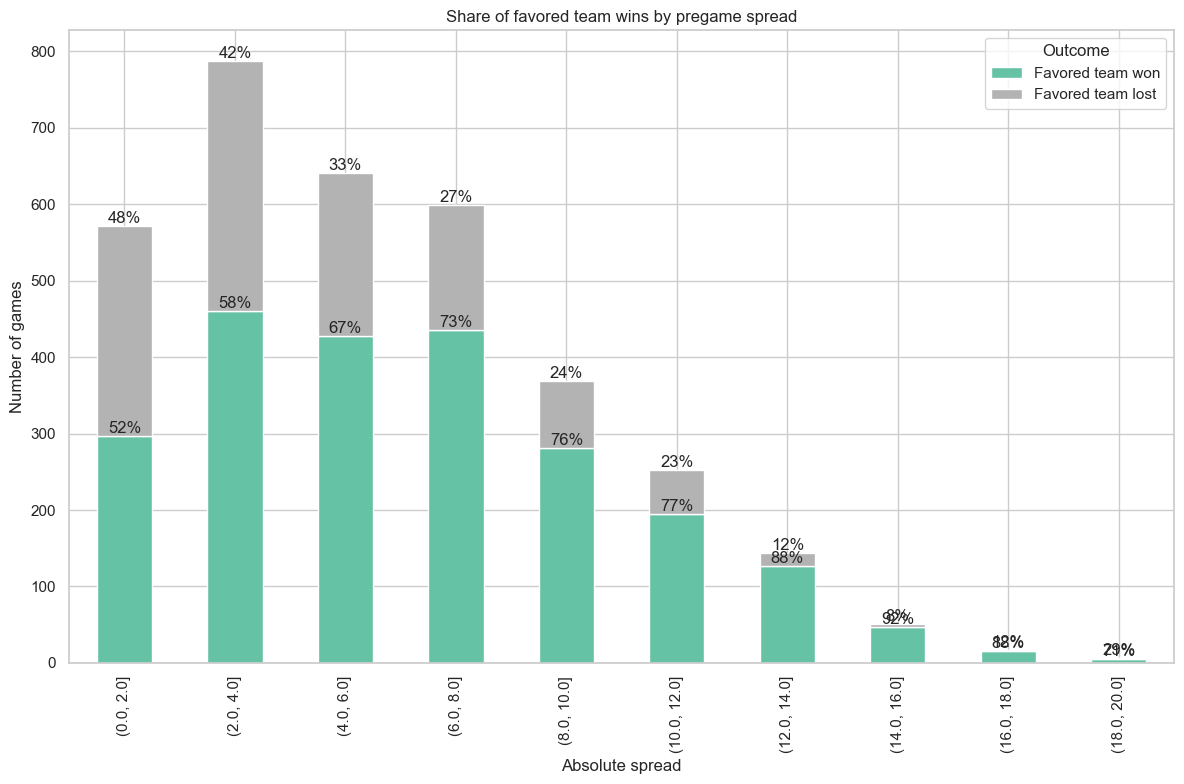

In [38]:
grouped = unique_games.groupby(['abs_line_bins', 'favored_team_won'])['favored_team_won'].count().unstack()
grouped = grouped[[1, 0]]
total_counts = grouped.sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 8))
grouped.plot(kind='bar', stacked=True, colormap='Set2', ax=ax)
ax.set_xlabel("Absolute spread")
ax.set_ylabel("Number of games")
plt.title("Share of favored team wins by pregame spread")
plt.legend(title="Outcome", labels=["Favored team won", "Favored team lost"], loc='upper right')
lower_bars = []
for p, x_loc in zip(ax.patches[:len(total_counts.index)], total_counts.index):
    percentage = f"{100 * p.get_height() / total_counts[x_loc]:.0f}%"
    x = p.get_x() + p.get_width() / 2
    bar_height = p.get_height()
    lower_bars.append(bar_height)
    y = bar_height
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
for p, x_loc, y_loc in zip(ax.patches[len(total_counts.index):], total_counts.index, lower_bars):
    percentage = f"{100 * p.get_height() / total_counts[x_loc]:.0f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + y_loc
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [39]:
close_games = data[(data['time_left']<=60) & (data['time_left']>=10) & (abs(data['margin'])<=5)]
# close_games = close_games.drop_duplicates('game_id', keep='first')

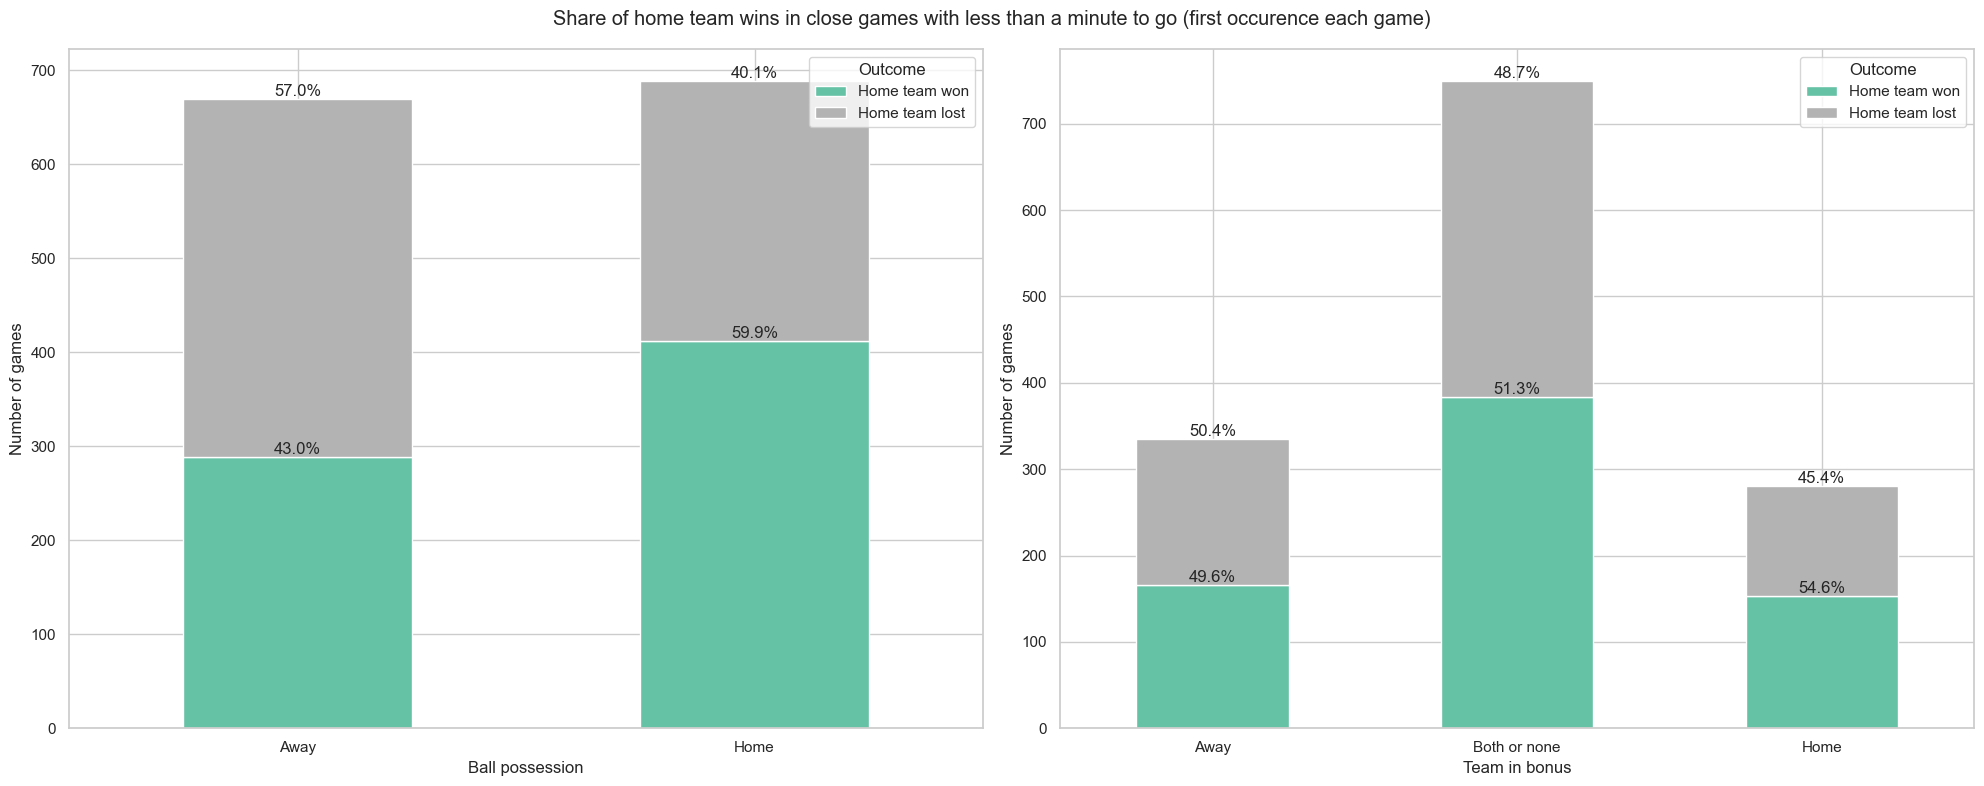

In [40]:
grouped_by_possession = close_games[[hpp in (0, 1) for hpp in close_games['home_possession_prob']]].drop_duplicates('game_id', keep='first').groupby(['home_possession_prob', 'home_team_won']).size().unstack()
grouped_by_possession = grouped_by_possession[[1, 0]]
total_counts_by_possession = grouped_by_possession.sum(axis=1)

grouped_by_bonus = close_games.drop_duplicates('game_id', keep='first').groupby(['bonus', 'home_team_won']).size().unstack()
grouped_by_bonus = grouped_by_bonus[[1, 0]]
total_counts_by_bonus = grouped_by_bonus.sum(axis=1)

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)
fig.suptitle("Share of home team wins in close games with less than a minute to go (first occurence each game)")

grouped_by_possession.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0])
x_labels_possession = ["Away", "Home"]
axes[0].set_xticks(range(len(x_labels_possession)))
axes[0].set_xticklabels(x_labels_possession, rotation=0)
axes[0].set_xlabel("Ball possession")
axes[0].set_ylabel("Number of games")
axes[0].legend(title="Outcome", labels=["Home team won", "Home team lost"], loc='upper right')
lower_bars = []
for p, x_loc in zip(axes[0].patches[:len(total_counts_by_possession.index)], total_counts_by_possession.index):
    percentage = f"{100 * p.get_height() / total_counts_by_possession[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    bar_height = p.get_height()
    lower_bars.append(bar_height)
    y = bar_height
    axes[0].annotate(percentage, (x, y), ha='center', va='bottom')
for p, x_loc, y_loc in zip(axes[0].patches[len(total_counts_by_possession.index):], total_counts_by_possession.index, lower_bars):
    percentage = f"{100 * p.get_height() / total_counts_by_possession[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + y_loc
    axes[0].annotate(percentage, (x, y), ha='center', va='bottom')
    
grouped_by_bonus.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1])
x_labels_bonus = ["Away", "Both or none", "Home"]
axes[1].set_xticks(range(len(x_labels_bonus)))
axes[1].set_xticklabels(x_labels_bonus, rotation=0)
axes[1].set_xlabel("Team in bonus")
axes[1].set_ylabel("Number of games")
axes[1].legend(title="Outcome", labels=["Home team won", "Home team lost"], loc='upper right')
lower_bars = []
for p, x_loc in zip(axes[1].patches[:len(total_counts_by_bonus.index)], total_counts_by_bonus.index):
    percentage = f"{100 * p.get_height() / total_counts_by_bonus[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    bar_height = p.get_height()
    lower_bars.append(bar_height)
    y = bar_height
    axes[1].annotate(percentage, (x, y), ha='center', va='bottom')
for p, x_loc, y_loc in zip(axes[1].patches[len(total_counts_by_bonus.index):], total_counts_by_bonus.index, lower_bars):
    percentage = f"{100 * p.get_height() / total_counts_by_bonus[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + y_loc
    axes[1].annotate(percentage, (x, y), ha='center', va='bottom')
    


plt.tight_layout()
plt.show()


In [41]:
close_games = copy.deepcopy(close_games)
close_games['free_throws_awarded'] = [1 if ft > 0 else -1 if ft < 0 else 0 for ft in close_games['home_team_free_throws']]
close_games['opp_ejections'] = [-1 if e > 0 else 1 if e < 0 else 0 for e in close_games['ejections']]

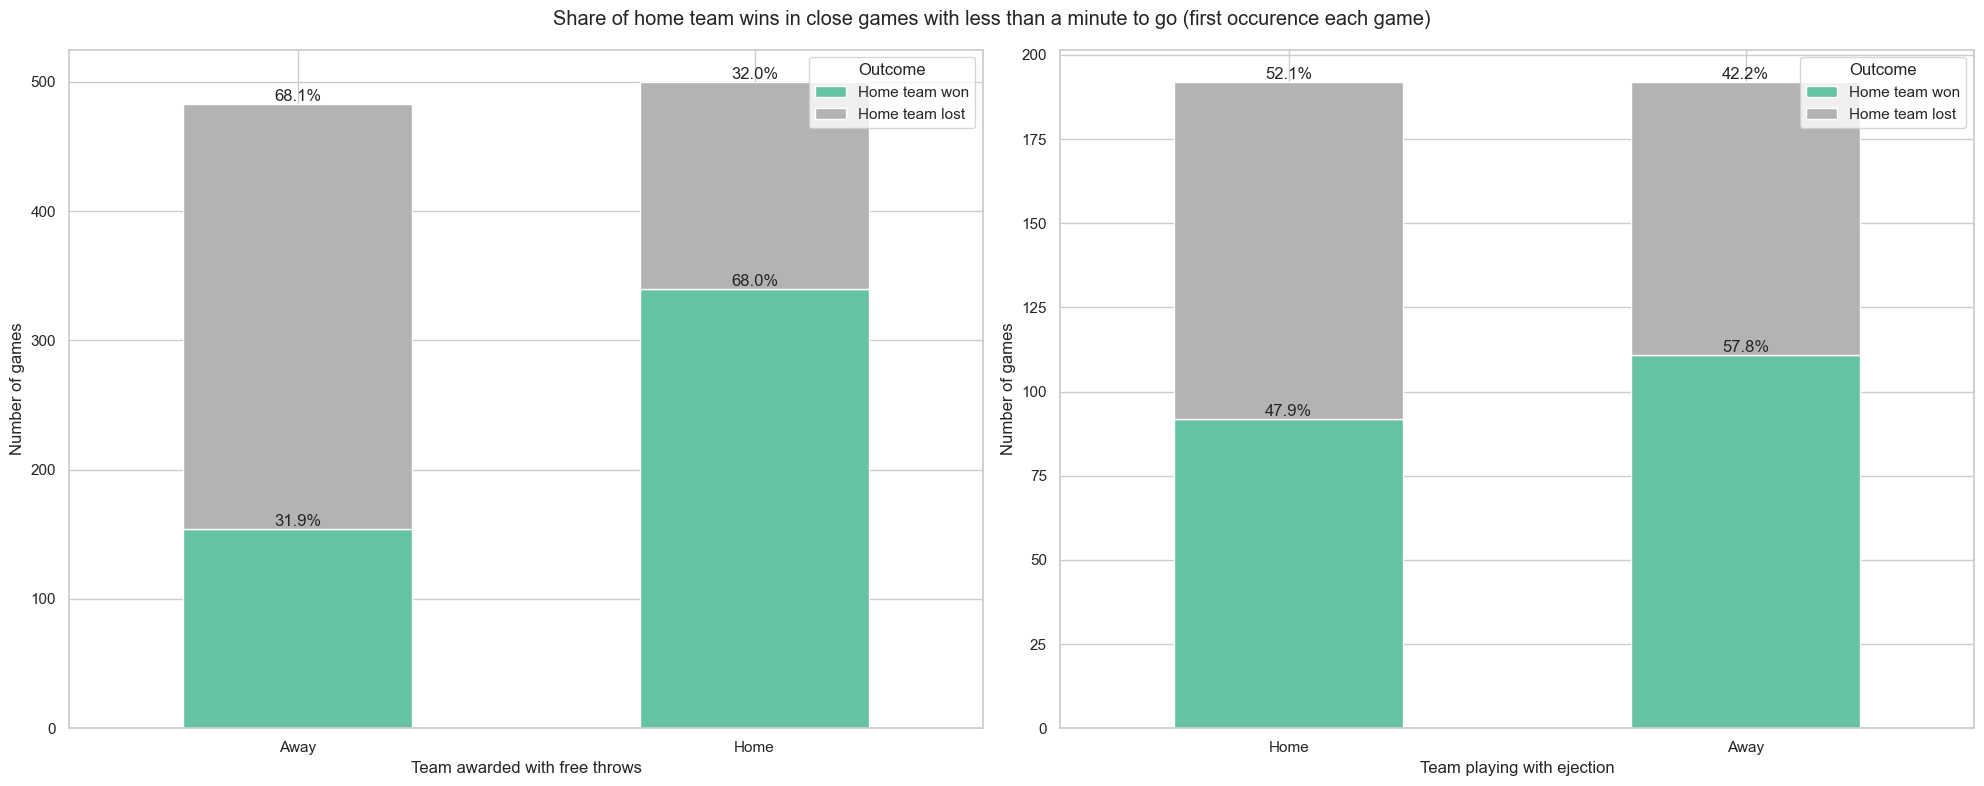

In [42]:
close_games_ft = close_games[close_games['free_throws_awarded']!=0]
close_games_ft = close_games_ft.drop_duplicates('game_id', keep='first')
grouped_by_fts = close_games_ft.groupby(['free_throws_awarded', 'home_team_won']).size().unstack()
grouped_by_fts = grouped_by_fts[[1, 0]]
total_counts_by_fts = grouped_by_fts.sum(axis=1)

close_games_e = close_games[close_games['opp_ejections']!=0]
close_games_e = close_games_e.drop_duplicates('game_id', keep='first')
grouped_by_e = close_games_e.groupby(['opp_ejections', 'home_team_won']).size().unstack()
grouped_by_e = grouped_by_e[[1, 0]]
total_counts_by_e = grouped_by_e.sum(axis=1)

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=2)
fig.suptitle("Share of home team wins in close games with less than a minute to go (first occurence each game)")

grouped_by_fts.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0])
x_labels_fts = ["Away", "Home"]
axes[0].set_xticks(range(len(x_labels_fts)))
axes[0].set_xticklabels(x_labels_fts, rotation=0)
axes[0].set_xlabel("Team awarded with free throws")
axes[0].set_ylabel("Number of games")
axes[0].legend(title="Outcome", labels=["Home team won", "Home team lost"], loc='upper right')
lower_bars = []
for p, x_loc in zip(axes[0].patches[:len(total_counts_by_fts.index)], total_counts_by_fts.index):
    percentage = f"{100 * p.get_height() / total_counts_by_fts[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    bar_height = p.get_height()
    lower_bars.append(bar_height)
    y = bar_height
    axes[0].annotate(percentage, (x, y), ha='center', va='bottom')
for p, x_loc, y_loc in zip(axes[0].patches[len(total_counts_by_fts.index):], total_counts_by_fts.index, lower_bars):
    percentage = f"{100 * p.get_height() / total_counts_by_fts[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + y_loc
    axes[0].annotate(percentage, (x, y), ha='center', va='bottom')
    
grouped_by_e.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1])
x_labels_ejections = ["Home", "Away"]
axes[1].set_xticks(range(len(x_labels_ejections)))
axes[1].set_xticklabels(x_labels_ejections, rotation=0)
axes[1].set_xlabel("Team playing with ejection")
axes[1].set_ylabel("Number of games")
axes[1].legend(title="Outcome", labels=["Home team won", "Home team lost"], loc='upper right')
lower_bars = []
for p, x_loc in zip(axes[1].patches[:len(total_counts_by_e.index)], total_counts_by_e.index):
    percentage = f"{100 * p.get_height() / total_counts_by_e[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    bar_height = p.get_height()
    lower_bars.append(bar_height)
    y = bar_height
    axes[1].annotate(percentage, (x, y), ha='center', va='bottom')
for p, x_loc, y_loc in zip(axes[1].patches[len(total_counts_by_e.index):], total_counts_by_e.index, lower_bars):
    percentage = f"{100 * p.get_height() / total_counts_by_e[x_loc]:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + y_loc
    axes[1].annotate(percentage, (x, y), ha='center', va='bottom')
    
plt.tight_layout()
plt.show()


## 2. Benchmark model

In [43]:
def game_train_test_split(unique_game_ids, X, y, test_size=0.2, oversample_factor=0.0, seed=123):
    rng = np.random.default_rng(seed)
    test_game_ids = rng.choice(unique_game_ids, int(test_size*len(unique_game_ids)), replace=False)
    train_index = data[~data['game_id'].isin(test_game_ids)].index
    close_games_index = data[(data['time_left']<=60)&(~data['game_id'].isin(test_game_ids))].index
    close_games_oversample = rng.choice(close_games_index, int(oversample_factor*len(close_games_index)))
    train_index = np.hstack([train_index, close_games_oversample])
    test_index = data[data['game_id'].isin(test_game_ids)].index
    X_train = X[train_index,:]
    X_test = X[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]
    return test_game_ids, X_train, X_test, y_train, y_test

In [44]:
features = [
    "time_left",
    "margin",
    "line",
    "home_team_won",
]

In [45]:
X = np.array(data[features[:-1]])
y = np.array(data[features[-1]])
_, X_train, X_test, y_train, y_test = game_train_test_split(data['game_id'].unique(), X, y, test_size=0.2)

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
y_pred_proba = [probs[1] for probs in model.predict_proba(X_test)]
y_pred = list(map(lambda x: int(x>=0.5), y_pred_proba))

In [48]:
print("Accuracy: ", accuracy_score(y_pred, y_test))
print("ROC AUC: ", roc_auc_score(y_pred, y_test))

Accuracy:  0.7653226799950722
ROC AUC:  0.7596970733858465


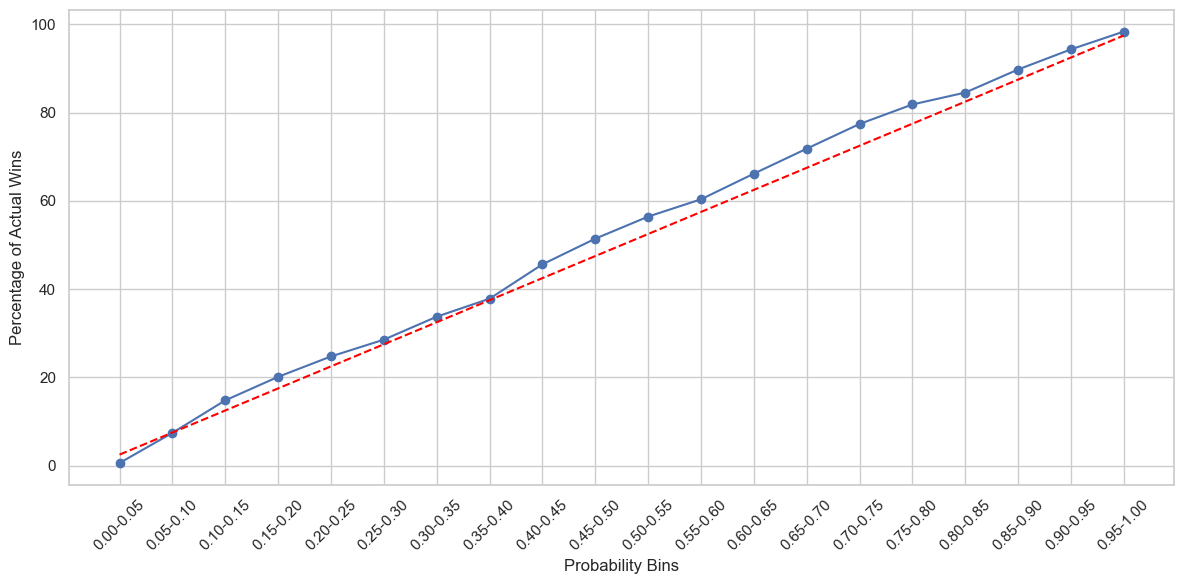

In [49]:
bin_edges = np.arange(0, 1.05, 0.05)

bin_indices = np.digitize(y_pred_proba, bin_edges)
percentage_wins = [np.mean(y_test[bin_indices == i]) * 100 for i in range(1, len(bin_edges))]

fig = plt.figure(figsize=(12,6))

plt.plot(np.arange(len(bin_edges) - 1), percentage_wins, marker='o', label='Percentage of Actual Wins')
plt.plot(np.arange(len(bin_edges) - 1), [np.mean([bin_edges[i], bin_edges[i+1]]) * 100 for i in range(len(bin_edges) - 1)], linestyle='--', color='red', label='Midpoint')
plt.xticks(np.arange(len(bin_edges) - 1), [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)], rotation=45)
plt.xlabel('Probability Bins')
plt.ylabel('Percentage of Actual Wins')
plt.tight_layout()
plt.show()

In [50]:
test_df = pd.DataFrame(np.hstack([X_test,y_test.reshape(y_test.shape[0],1)]), columns=features)
test_df['prediction'] = y_pred
test_df['prediction_correct'] = (test_df['prediction'] == test_df['home_team_won']).astype(int)
test_df['time_left_bins'] = pd.cut(test_df['time_left'], bins=np.linspace(0,2880,25))

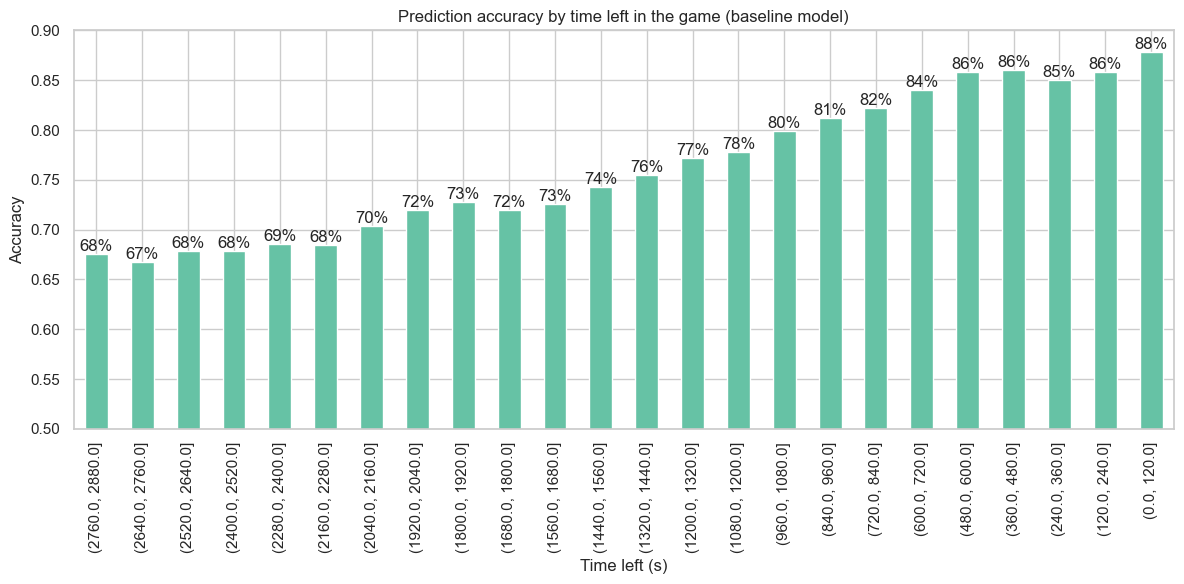

In [51]:
grouped = test_df.groupby(['time_left_bins'])['prediction_correct'].mean()
grouped = grouped.reindex(grouped.index[::-1])
fig, ax = plt.subplots(figsize=(12, 6))
grouped.plot(kind='bar', colormap='Set2', ax=ax)
ax.set_ylim([0.5,0.9])
ax.set_xlabel("Time left (s)")
ax.set_ylabel("Accuracy")
plt.title("Prediction accuracy by time left in the game (baseline model)")
for p in ax.patches:
    percentage = f"{100 * p.get_height():.0f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## 3. Feature selection

In [52]:
features = [
    "home_possession_prob",
    "home_team_free_throws",
    'bonus',
    'ejections',
    "time_left",          
    "margin",
    "line",
    "time_pressure",
    "home_team_won",
]

In [53]:
X = np.array(data[features[:-1]])
y = np.array(data[features[-1]])
test_game_ids, X_train, X_test, y_train, y_test = game_train_test_split(data['game_id'].unique(), X, y, test_size=0.2, oversample_factor=10)

In [54]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

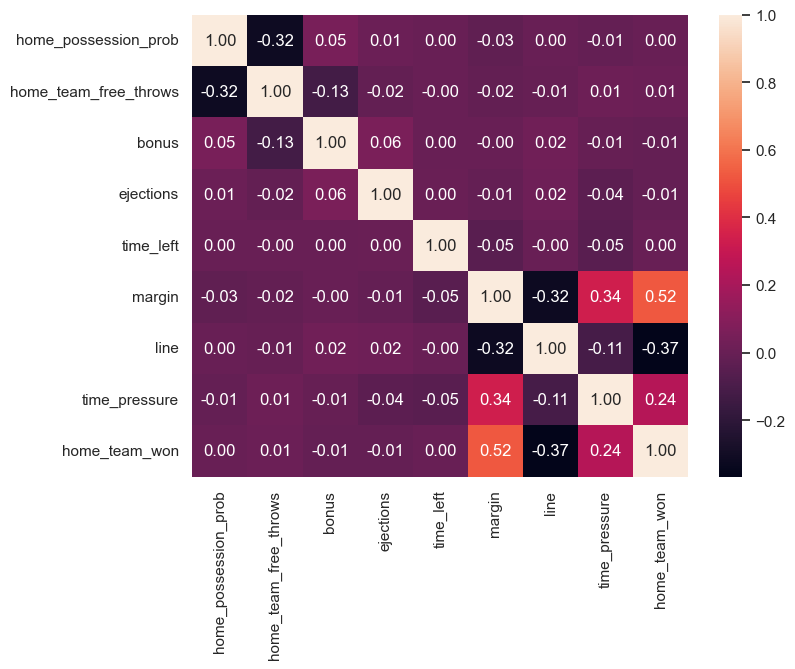

In [55]:
corr_matrix = data[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [56]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [57]:
def select_features(X_train, X_test, y_train, y_test, features=[]):
    selected_features = []
    best_overall_accuracy = 0.0
    while True:
        feature_to_add = None
        best_feature_accuracy = best_overall_accuracy
        for feature in range(X.shape[1]):
            if feature not in selected_features:
                current_features = selected_features + [feature]
                X_train_subset = X_train[:, current_features]
                X_test_subset = X_test[:, current_features]
                model = LogisticRegression(max_iter=100)
                accuracy = evaluate_model(model, X_train_subset, X_test_subset, y_train, y_test)
                if accuracy > best_feature_accuracy:
                    best_feature_accuracy = accuracy
                    feature_to_add = feature
        if feature_to_add is not None:
            selected_features.append(feature_to_add)
            best_overall_accuracy = best_feature_accuracy
            if features:
                print("Added feature: ", features[feature_to_add])
                print("Current accuracy: ", best_overall_accuracy)
            else:
                print("Added feature: ", feature_to_add)
        else:
            break
    return selected_features

In [26]:
select_features(X_train, X_test, y_train, y_test, features=features)

Added feature:  margin
Current accuracy:  0.7346981745190654
Added feature:  line
Current accuracy:  0.7587571850676923
Added feature:  time_pressure
Current accuracy:  0.7655860699171129
Added feature:  home_team_free_throws
Current accuracy:  0.7657650386361882


[5, 6, 7, 1]

In [27]:
game_ends_X_train = X_train[np.where((X_train[:,4]<=60) & (abs(X_train[:,5])<=5))]
game_ends_X_test = X_test[np.where((X_test[:,4]<=60) & (abs(X_test[:,5])<=5))]
game_ends_y_train = y_train[np.where((X_train[:,4]<=60) & (abs(X_train[:,5])<=5))]
game_ends_y_test = y_test[np.where((X_test[:,4]<=60) & (abs(X_test[:,5])<=5))]

select_features(game_ends_X_train, game_ends_X_test, game_ends_y_train, game_ends_y_test, features=features)

Added feature:  time_pressure
Current accuracy:  0.8783382789317508
Added feature:  home_possession_prob
Current accuracy:  0.883131705090162
Added feature:  ejections
Current accuracy:  0.8838164802556494
Added feature:  bonus
Current accuracy:  0.8840447386441451


[7, 0, 3, 2]

## 4. Models

### 4.1. Logistic regression

In [58]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [59]:
lr_win_probs = [probs[1] for probs in lr.predict_proba(X_test)]
lr_win_preds = lr.predict(X_test)

In [60]:
print("ROC AUC: ", roc_auc_score(y_test, lr_win_probs))
print("Accuracy: ", accuracy_score(y_test, lr_win_preds))
print("Brier score: ", brier_score_loss(y_test, lr_win_probs))

ROC AUC:  0.8529925314638565
Accuracy:  0.7702680347054786
Brier score:  0.15421167798417826


### 4.2. Neural network

In [40]:
# from tensorflow import keras
# from itertools import product

# # Define hyperparameter combinations to test
# layer_sizes = [8, 16, 32]
# hidden_layers = [1, 2, 3]

# # Create a list of all possible hyperparameter combinations
# layers_list = [[4], [8], [8,4], [16, 8], [16, 4], [16, 8, 4]]
# for layer_sizes in layers_list:
#     model = keras.Sequential()
# #     model.add(keras.layers.Dense(layer_size, activation='relu', input_shape=(input_shape,)))
    
#     for layer_size in layer_sizes:
#         model.add(keras.layers.Dense(layer_size, activation='relu'))
    
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
#     early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1, restore_best_weights=True)
#     history = model.fit(X_train, y_train, epochs=100, batch_size=32,
#                     validation_data=(X_test, y_test), shuffle=True,
#                     callbacks=[early_stopping])
    
#     # You can also store or print relevant information for each combination, such as the best validation score, etc.
#     print(f"Layers: {len(layer_sizes)}, Layer Size: {layer_sizes}, Best Validation AUC: {max(history.history['val_auc'])}")


In [46]:
model = keras.Sequential([
     keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

In [47]:
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), shuffle=True,
                    callbacks=[early_stopping])

Epoch 1/100
48976/48976 [==============================] - 96s 2ms/step - loss: 0.3955 - accuracy: 0.8051 - auc: 0.8961 - val_loss: 0.4582 - val_accuracy: 0.7765 - val_auc: 0.8572
Epoch 2/100
48976/48976 [==============================] - 109s 2ms/step - loss: 0.3750 - accuracy: 0.8148 - auc: 0.9062 - val_loss: 0.4574 - val_accuracy: 0.7753 - val_auc: 0.8579
Epoch 3/100
48976/48976 [==============================] - 111s 2ms/step - loss: 0.3731 - accuracy: 0.8151 - auc: 0.9067 - val_loss: 0.4558 - val_accuracy: 0.7763 - val_auc: 0.8584
Epoch 4/100
48976/48976 [==============================] - 114s 2ms/step - loss: 0.3723 - accuracy: 0.8152 - auc: 0.9069 - val_loss: 0.4579 - val_accuracy: 0.7752 - val_auc: 0.8585
Epoch 5/100
48976/48976 [==============================] - 81s 2ms/step - loss: 0.3718 - accuracy: 0.8154 - auc: 0.9070 - val_loss: 0.4552 - val_accuracy: 0.7770 - val_auc: 0.8584
Epoch 6/100
48976/48976 [==============================] - 84s 2ms/step - loss: 0.3717 - accuracy

In [ ]:
# pickle.dump(model, open('nn_model.pkl', 'wb'))

In [61]:
model = pickle.load(open('nn_model.pkl', 'rb'))

In [62]:
nn_win_probs = model.predict(X_test)
nn_win_probs = pd.Series(nn_win_probs.reshape(nn_win_probs.shape[0],))
nn_win_preds = (nn_win_probs >= 0.5).astype(int)

8879/8879 [==============================] - 14s 2ms/step


In [63]:
print("ROC AUC: ", roc_auc_score(y_test, nn_win_probs))
print("Accuracy: ", accuracy_score(y_test, nn_win_preds))
print("Brier score: ", brier_score_loss(y_test, nn_win_probs))

ROC AUC:  0.8585273329378452
Accuracy:  0.7752415480192183
Brier score:  0.1517849401718678


### 4.3. XGBoost

In [64]:
# xgb_classifier = xgb.XGBClassifier()

# param_grid = {
#     'n_estimators': [100],#, 200, 300],
#     'learning_rate': [0.1],
#     'max_depth': [1, 3, 6, 10],
#     'min_child_weight': [1, 2, 3, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'objective': ['binary:logistic'],
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=3)

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and corresponding ROC AUC score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best ROC AUC Score:", best_score)

# # Evaluate the model with the best parameters on the test set
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# roc_auc_test = roc_auc_score(y_test, y_pred)
# print("ROC AUC on Test Set:", roc_auc_test)

In [65]:
# xgbc = grid_search.best_estimator_
xgbc = xgb.XGBClassifier(learning_rate=0.1, max_depth=3,
                         min_child_weight=1, n_estimators=100,
                         objective='binary:logistic', colsample_bytree=0.9, subsample=0.8)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [66]:
xgb_win_probs = [pred[1] for pred in xgbc.predict_proba(X_test)]
xgb_win_preds = xgbc.predict(X_test)

In [67]:
print("ROC AUC: ", roc_auc_score(y_test, xgb_win_probs))
print("Accuracy: ", accuracy_score(y_test, xgb_win_preds))
print("Brier score: ", brier_score_loss(y_test, xgb_win_probs))

ROC AUC:  0.8572677596016467
Accuracy:  0.7757272839267172
Brier score:  0.15193139193497485


## 5. Evaluation

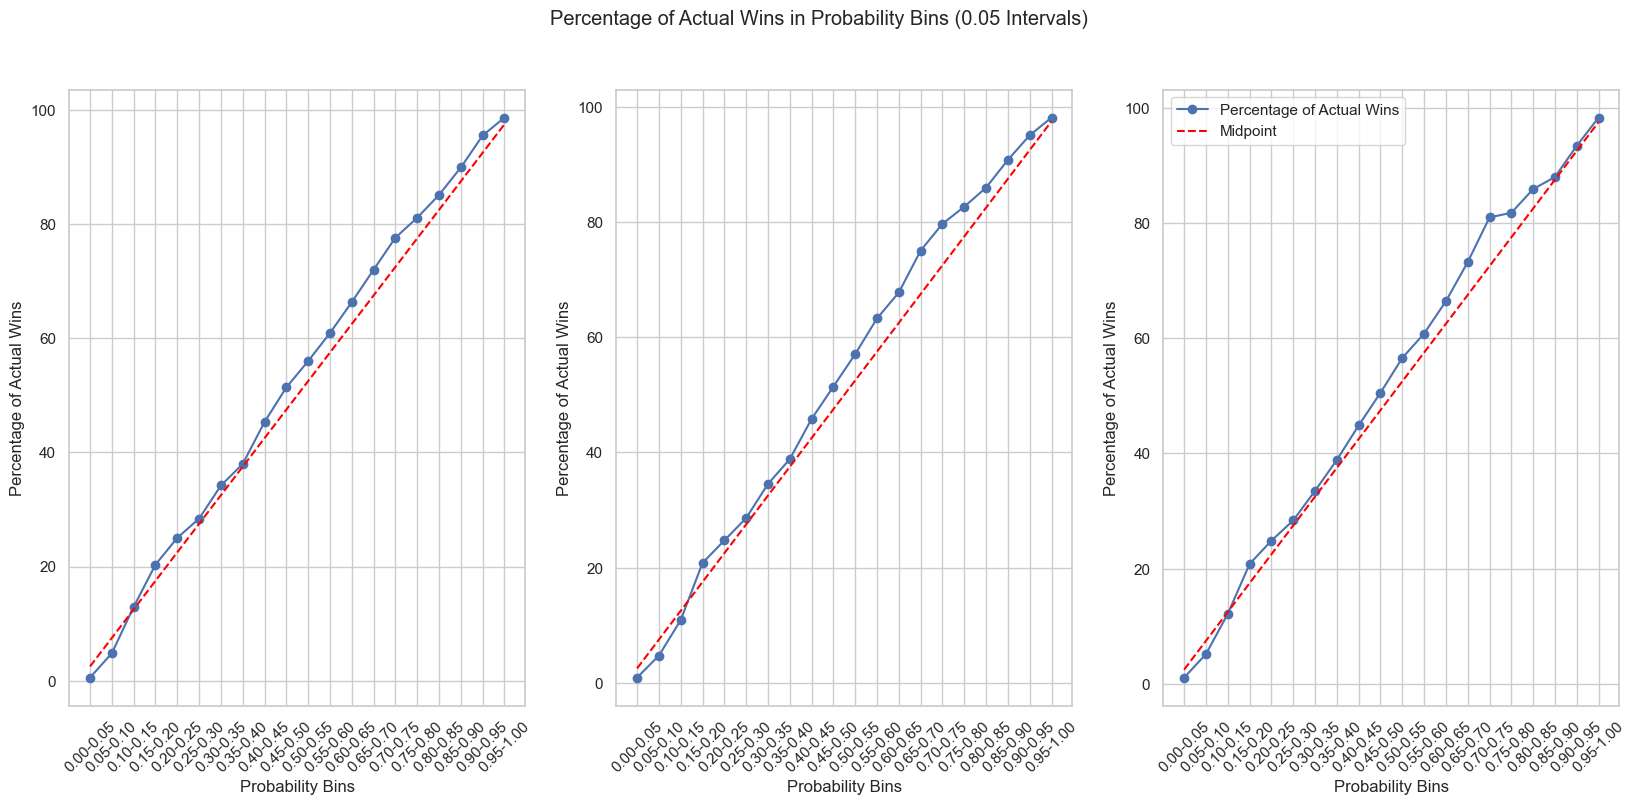

In [68]:
bin_edges = np.arange(0, 1.05, 0.05)

lr_bin_indices = np.digitize(lr_win_probs, bin_edges)
nn_bin_indices = np.digitize(nn_win_probs, bin_edges)
xgb_bin_indices = np.digitize(xgb_win_probs, bin_edges)

lr_percentage_wins = [np.mean(y_test[lr_bin_indices == i]) * 100 for i in range(1, len(bin_edges))]
nn_percentage_wins = [np.mean(y_test[nn_bin_indices == i]) * 100 for i in range(1, len(bin_edges))]
xgb_percentage_wins = [np.mean(y_test[xgb_bin_indices == i]) * 100 for i in range(1, len(bin_edges))]

fig, axes = plt.subplots(figsize=(20,8), nrows=1, ncols=3)

axes[0].plot(np.arange(len(bin_edges) - 1), lr_percentage_wins, marker='o', label='Percentage of Actual Wins')
axes[0].plot(np.arange(len(bin_edges) - 1), [np.mean([bin_edges[i], bin_edges[i+1]]) * 100 for i in range(len(bin_edges) - 1)], linestyle='--', color='red', label='Midpoint')
axes[0].set_xticks(np.arange(len(bin_edges) - 1), [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)], rotation=45)
axes[0].set_xlabel('Probability Bins')
axes[0].set_ylabel('Percentage of Actual Wins')

axes[1].plot(np.arange(len(bin_edges) - 1), nn_percentage_wins, marker='o', label='Percentage of Actual Wins')
axes[1].plot(np.arange(len(bin_edges) - 1), [np.mean([bin_edges[i], bin_edges[i+1]]) * 100 for i in range(len(bin_edges) - 1)], linestyle='--', color='red', label='Midpoint')
axes[1].set_xticks(np.arange(len(bin_edges) - 1), [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)], rotation=45)
axes[1].set_xlabel('Probability Bins')
axes[1].set_ylabel('Percentage of Actual Wins')

axes[2].plot(np.arange(len(bin_edges) - 1), xgb_percentage_wins, marker='o', label='Percentage of Actual Wins')
axes[2].plot(np.arange(len(bin_edges) - 1), [np.mean([bin_edges[i], bin_edges[i+1]]) * 100 for i in range(len(bin_edges) - 1)], linestyle='--', color='red', label='Midpoint')
axes[2].set_xticks(np.arange(len(bin_edges) - 1), [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)], rotation=45)
axes[2].set_xlabel('Probability Bins')
axes[2].set_ylabel('Percentage of Actual Wins')

plt.suptitle('Percentage of Actual Wins in Probability Bins (0.05 Intervals)')
plt.grid(True)
plt.legend()
plt.show()

In [69]:
test_data = copy.deepcopy(data[data['game_id'].isin(test_game_ids)])

In [71]:
test_data['quarter'] = test_data['period'].apply(lambda x: f'Q{x}' if x <= 4 else 'OT')
test_data.loc[test_data[test_data['time_left']==2880].index, 'quarter'] = 'Start of Game'
test_data['time_left_bins'] = pd.cut(test_data['time_left'], bins=np.linspace(0,2880,49))

In [72]:
X_test_data = np.array(test_data[features[:-1]])
X_test_data = scaler.transform(X_test_data)

test_data['win_probability_nn'] = model.predict(X_test_data)
test_data['win_probability_lr'] = [probs[1] for probs in lr.predict_proba(X_test_data)]
test_data['win_probability_xgb'] = [probs[1] for probs in xgbc.predict_proba(X_test_data)]
test_data['win_prediction_nn'] = (test_data['win_probability_nn'] >= 0.5).astype(int)
test_data['win_prediction_lr'] = (test_data['win_probability_lr'] >= 0.5).astype(int)
test_data['win_prediction_xgb'] = (test_data['win_probability_xgb'] >= 0.5).astype(int)
test_data['prediction_correct_nn'] = (test_data['win_prediction_nn'] == test_data['home_team_won']).astype(int)
test_data['prediction_correct_lr'] = (test_data['win_prediction_lr'] == test_data['home_team_won']).astype(int)
test_data['prediction_correct_xgb'] = (test_data['win_prediction_xgb'] == test_data['home_team_won']).astype(int)

8879/8879 [==============================] - 15s 2ms/step


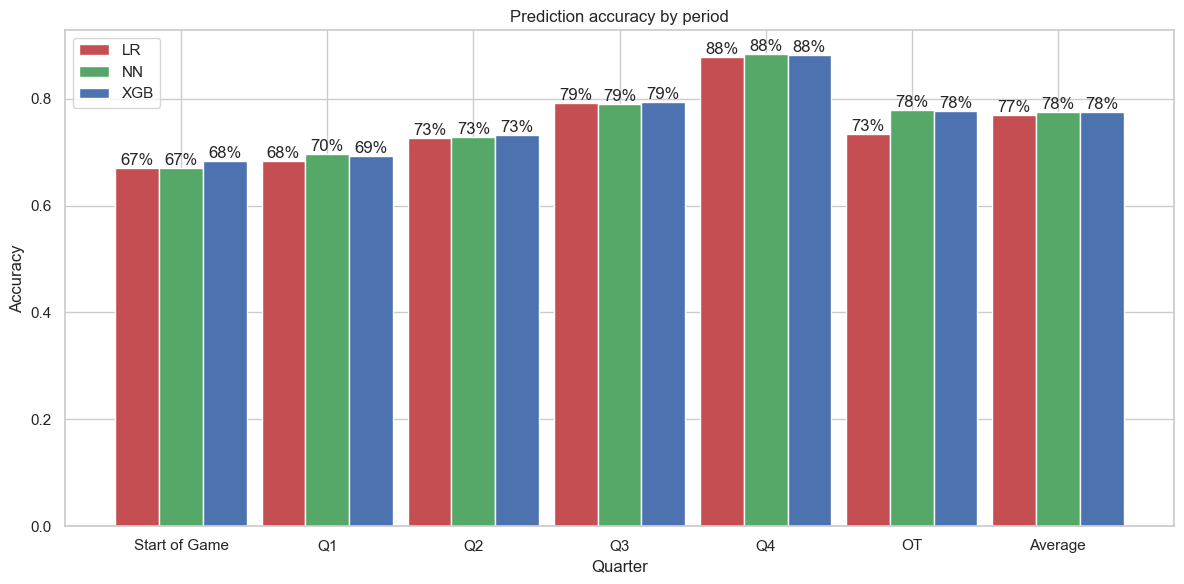

In [73]:
grouped_nn = test_data.groupby(['quarter'])['prediction_correct_nn'].mean()
grouped_lr = test_data.groupby(['quarter'])['prediction_correct_lr'].mean()
grouped_xgb = test_data.groupby(['quarter'])['prediction_correct_xgb'].mean()

grouped_nn['Average'] = test_data['prediction_correct_nn'].mean()
grouped_lr['Average'] = test_data['prediction_correct_lr'].mean()
grouped_xgb['Average'] = test_data['prediction_correct_xgb'].mean()


index_order = ['Start of Game', 'Q1', 'Q2', 'Q3', 'Q4', 'OT', 'Average']
grouped_nn = grouped_nn.reindex(index_order)
grouped_lr = grouped_lr.reindex(index_order)
grouped_xgb = grouped_xgb.reindex(index_order)

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.3  # Width of each bar

# Plot the first grouped series (prediction_correct_nn)
x = range(len(grouped_lr))
ax.bar(x, grouped_lr, width=width, label='LR', align='center', color='r')

# Plot the second grouped series (prediction_correct_lr) beside the first one
x_nn = [i + width for i in x]
ax.bar(x_nn, grouped_nn, width=width, label='NN', align='center', color='g')

# Plot the second grouped series (prediction_correct_lr) beside the first one
x_xgb = [i + 2*width for i in x]
ax.bar(x_xgb, grouped_xgb, width=width, label='XGB', align='center', color='b')

ax.set_xlabel("Quarter")
ax.set_ylabel("Accuracy")
plt.title("Prediction accuracy by period")

# Customize x-axis tick labels: make them vertical and smaller font
plt.xticks([i + width for i in x], labels=index_order)

# plt.ylim([0.5, 1])
for p in ax.patches:
    percentage = f"{100 * p.get_height():.0f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')  # Make annotation font smaller

plt.legend(loc='upper left')  # Add legend
plt.tight_layout()
plt.show()


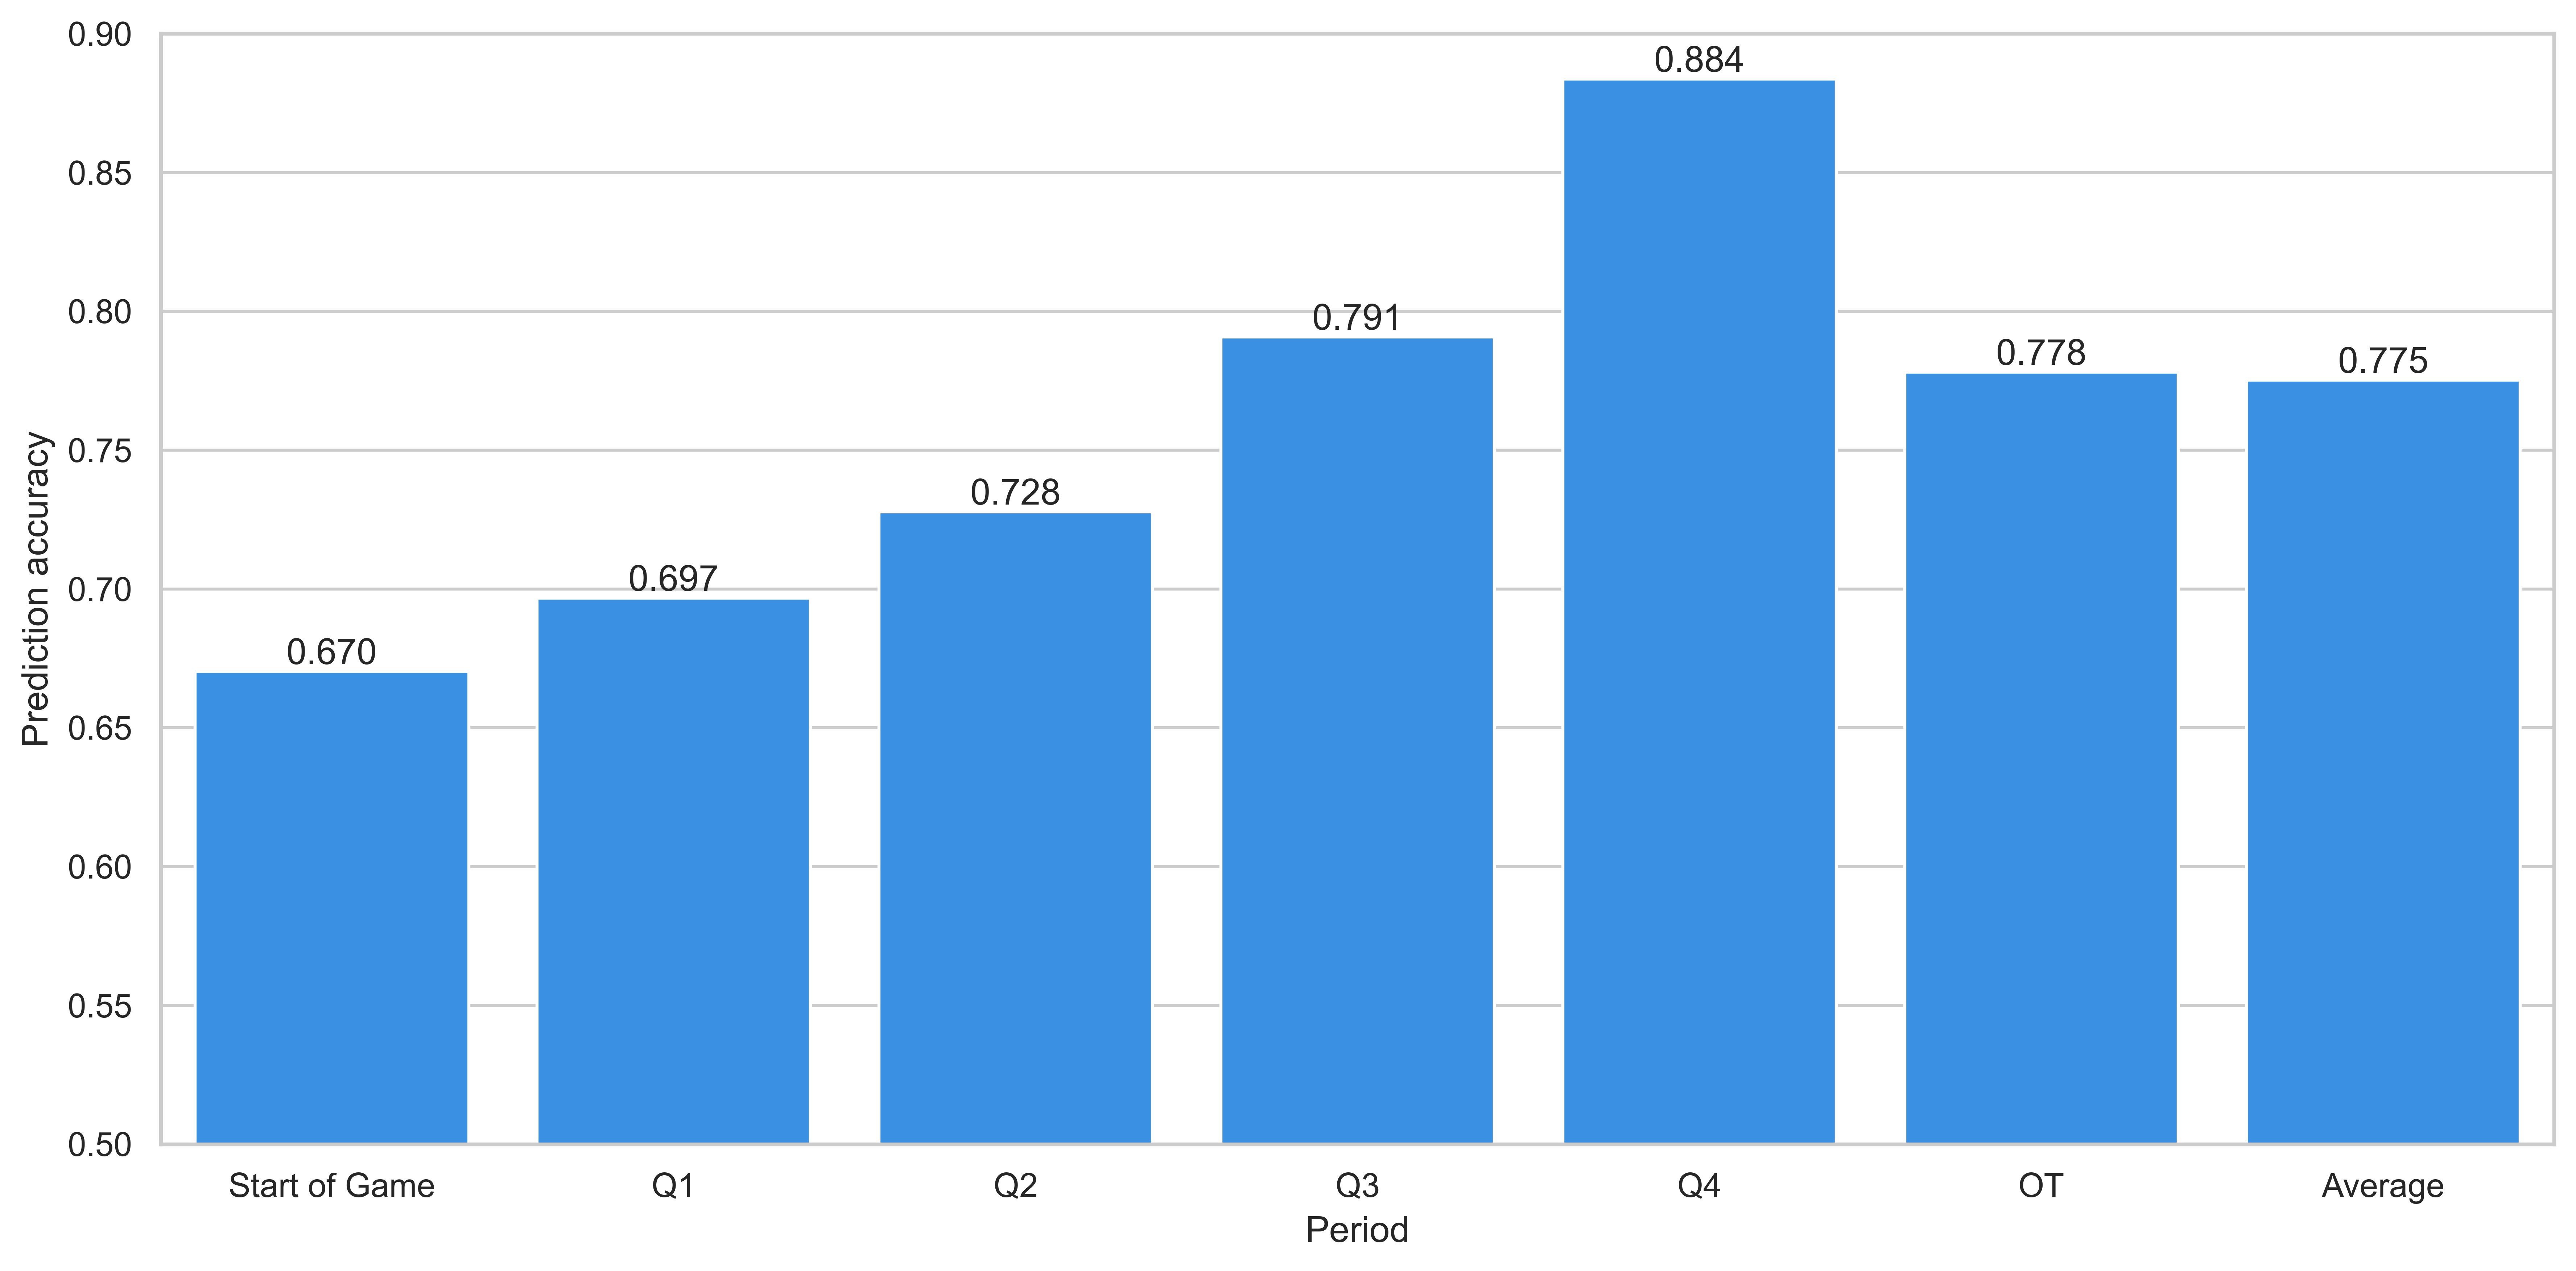

In [74]:
# Create a Seaborn barplot
fig = plt.figure(figsize=(12,6), dpi=600)

sns.set(style="whitegrid")  # Optional, sets the style of the plot
ax = sns.barplot(x=grouped_nn.index, y=grouped_nn.values, color='dodgerblue')
ax.set_xlabel('Period')
ax.set_ylabel('Prediction accuracy')
ax.set_ylim([0.5, 0.9])

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels())

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(format(p.get_height(), ".3f"), (x, y), ha='center', va='bottom')  # Make annotation font smaller

# Show the plot
plt.tight_layout()
plt.show()
fig.savefig('../figures/figure2.png')

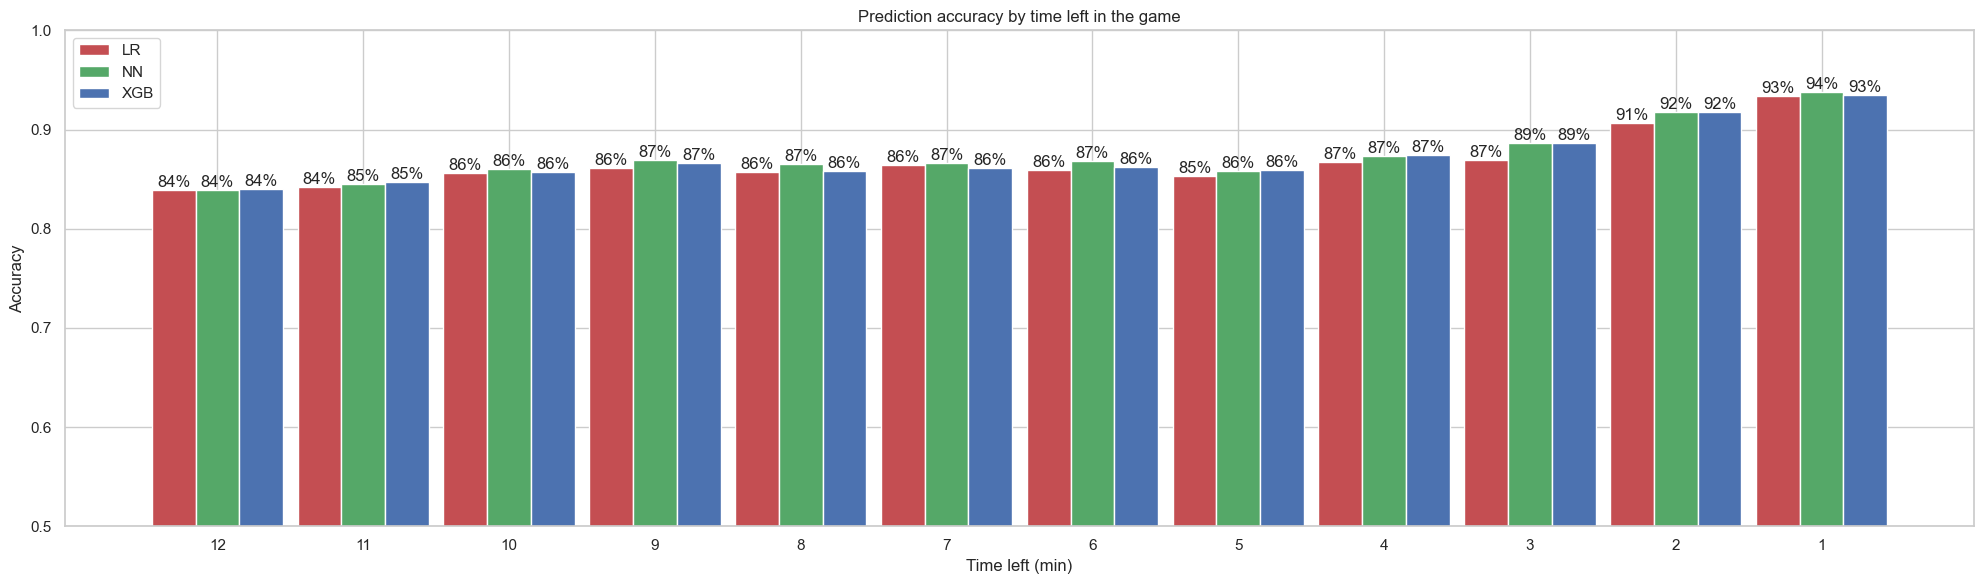

In [75]:
grouped_nn = test_data.groupby(['time_left_bins'])['prediction_correct_nn'].mean()
grouped_lr = test_data.groupby(['time_left_bins'])['prediction_correct_lr'].mean()
grouped_xgb = test_data.groupby(['time_left_bins'])['prediction_correct_xgb'].mean()

grouped_nn = grouped_nn.reindex(grouped_nn.index[::-1])[-12:]
grouped_lr = grouped_lr.reindex(grouped_lr.index[::-1])[-12:]
grouped_xgb = grouped_xgb.reindex(grouped_xgb.index[::-1])[-12:]

fig, ax = plt.subplots(figsize=(20,6))

width = 0.3  # Width of each bar

# Plot the first grouped series (prediction_correct_nn)
x = range(len(grouped_lr))
ax.bar(x, grouped_lr, width=width, label='LR', align='center', color='r')

# Plot the second grouped series (prediction_correct_lr) beside the first one
x_nn = [i + width for i in x]
ax.bar(x_nn, grouped_nn, width=width, label='NN', align='center', color='g')

# Plot the second grouped series (prediction_correct_lr) beside the first one
x_xgb = [i + 2*width for i in x]
ax.bar(x_xgb, grouped_xgb, width=width, label='XGB', align='center', color='b')

ax.set_xlabel("Time left (min)")
ax.set_ylabel("Accuracy")
plt.title("Prediction accuracy by time left in the game")

# Customize x-axis tick labels: make them vertical and smaller font
plt.xticks([i + width for i in x], labels=range(12,0,-1),)

plt.ylim([0.5, 1])
for p in ax.patches:
    percentage = f"{100 * p.get_height():.0f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')  # Make annotation font smaller

plt.legend(loc='upper left')  # Add legend
plt.tight_layout()
plt.show()


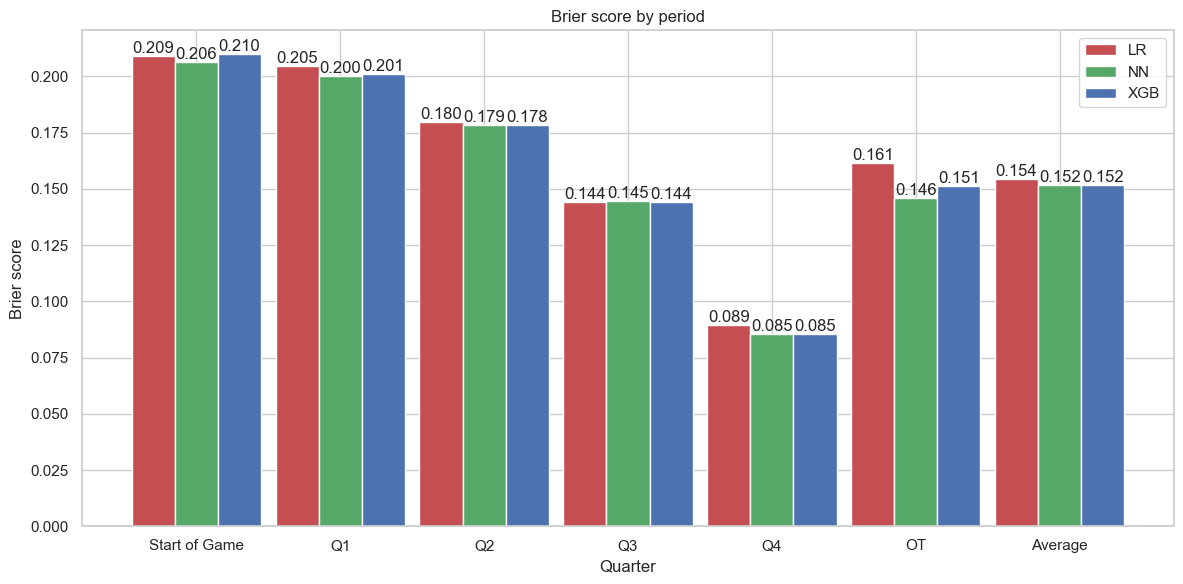

In [76]:
grouped_nn = test_data.groupby(['quarter']).apply(lambda x: brier_score_loss(x['home_team_won'], x['win_probability_nn']))
grouped_lr = test_data.groupby(['quarter']).apply(lambda x: brier_score_loss(x['home_team_won'], x['win_probability_lr']))
grouped_xgb = test_data.groupby(['quarter']).apply(lambda x: brier_score_loss(x['home_team_won'], x['win_probability_xgb']))

grouped_nn = grouped_nn.reindex(index_order)
grouped_lr = grouped_lr.reindex(index_order)
grouped_xgb = grouped_xgb.reindex(index_order)

grouped_nn['Average'] = brier_score_loss(test_data['home_team_won'], test_data['win_probability_nn'])
grouped_lr['Average'] = brier_score_loss(test_data['home_team_won'], test_data['win_probability_lr'])
grouped_xgb['Average'] = brier_score_loss(test_data['home_team_won'], test_data['win_probability_xgb'])

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.3  # Width of each bar

# Plot the first grouped series (prediction_correct_nn)
x = range(len(grouped_lr))
ax.bar(x, grouped_lr, width=width, label='LR', align='center', color='r')

# Plot the second grouped series (prediction_correct_lr) beside the first one
x_nn = [i + width for i in x]
ax.bar(x_nn, grouped_nn, width=width, label='NN', align='center', color='g')

# Plot the second grouped series (prediction_correct_lr) beside the first one
x_xgb = [i + 2*width for i in x]
ax.bar(x_xgb, grouped_xgb, width=width, label='XGB', align='center', color='b')

ax.set_xlabel("Quarter")
ax.set_ylabel("Brier score")
plt.title("Brier score by period")

# Customize x-axis tick labels: make them vertical and smaller font
plt.xticks([i + width for i in x], labels=index_order)

# plt.ylim([0.5, 1])
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f"{p.get_height():0.3f}", (x, y), ha='center', va='bottom')  # Make annotation font smaller

plt.legend(loc='upper right')  # Add legend
plt.tight_layout()
plt.show()


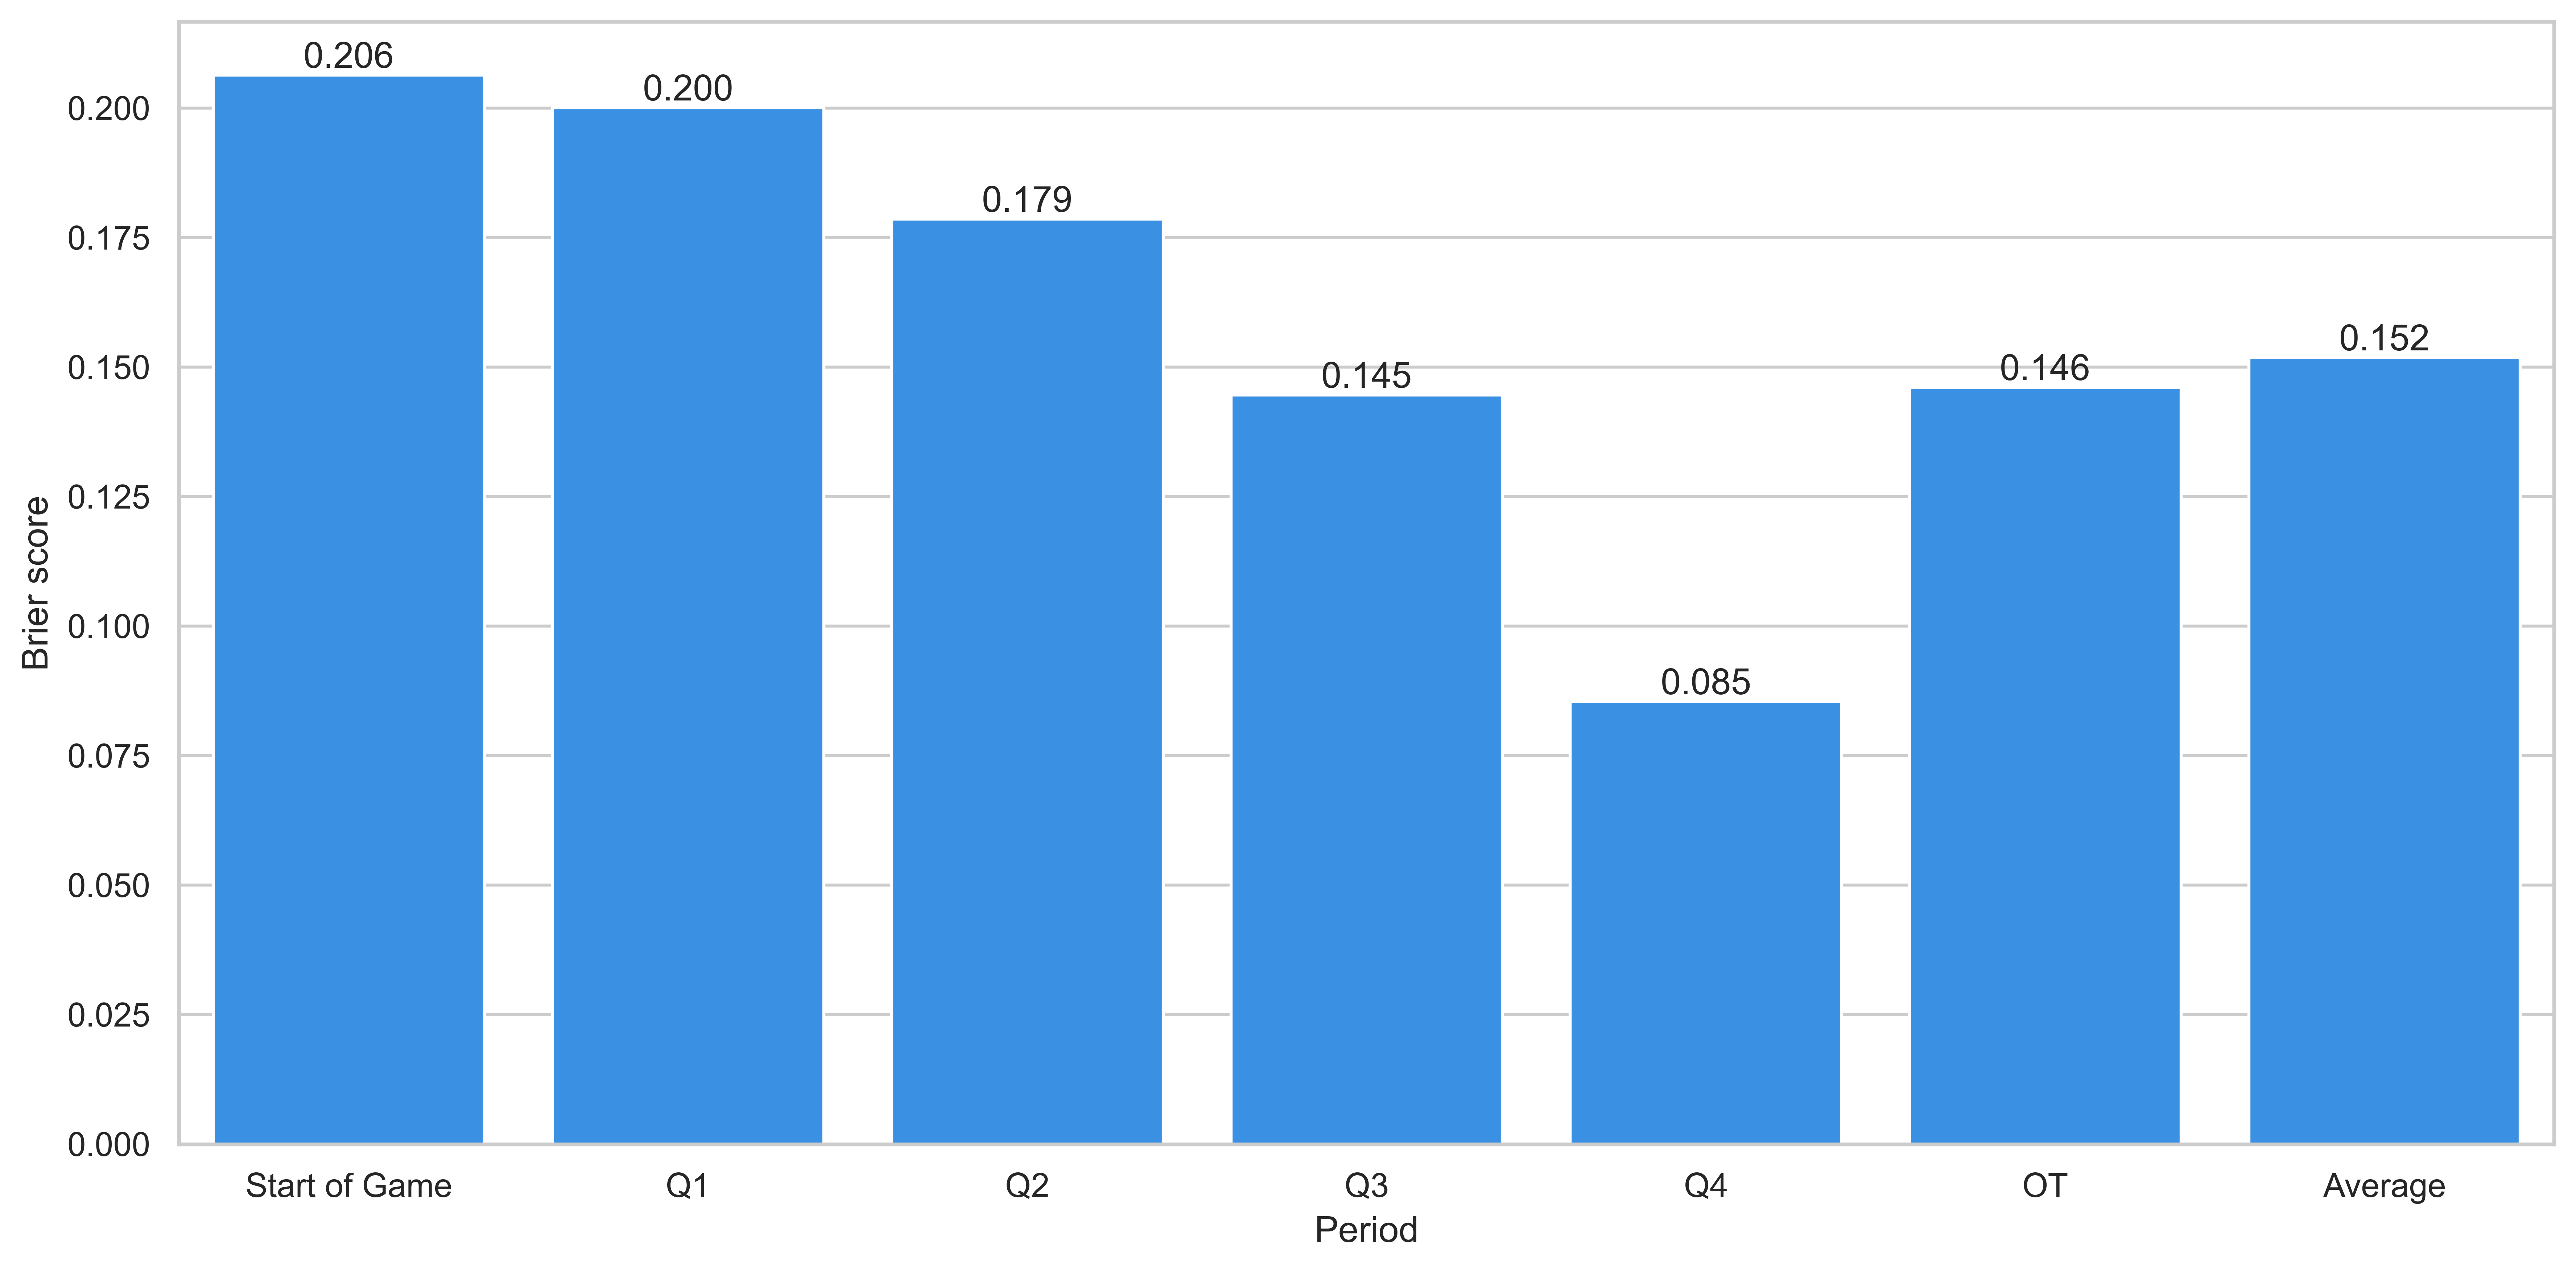

In [87]:
# Create a Seaborn barplot
fig = plt.figure(figsize=(12,6), dpi=600)

sns.set(style="whitegrid")  # Optional, sets the style of the plot
ax = sns.barplot(x=grouped_nn.index, y=grouped_nn.values, color='dodgerblue')
ax.set_xlabel('Period')
ax.set_ylabel('Brier score')
# ax.set_ylim([0.5, 0.9])

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels())

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(format(p.get_height(), ".3f"), (x, y), ha='center', va='bottom')  # Make annotation font smaller

# Show the plot
plt.tight_layout()
plt.show()
fig.savefig('../figures/figure3.png')

In [41]:
random_game = np.random.choice(test_game_ids)

12/12 [==============================] - 0s 2ms/step


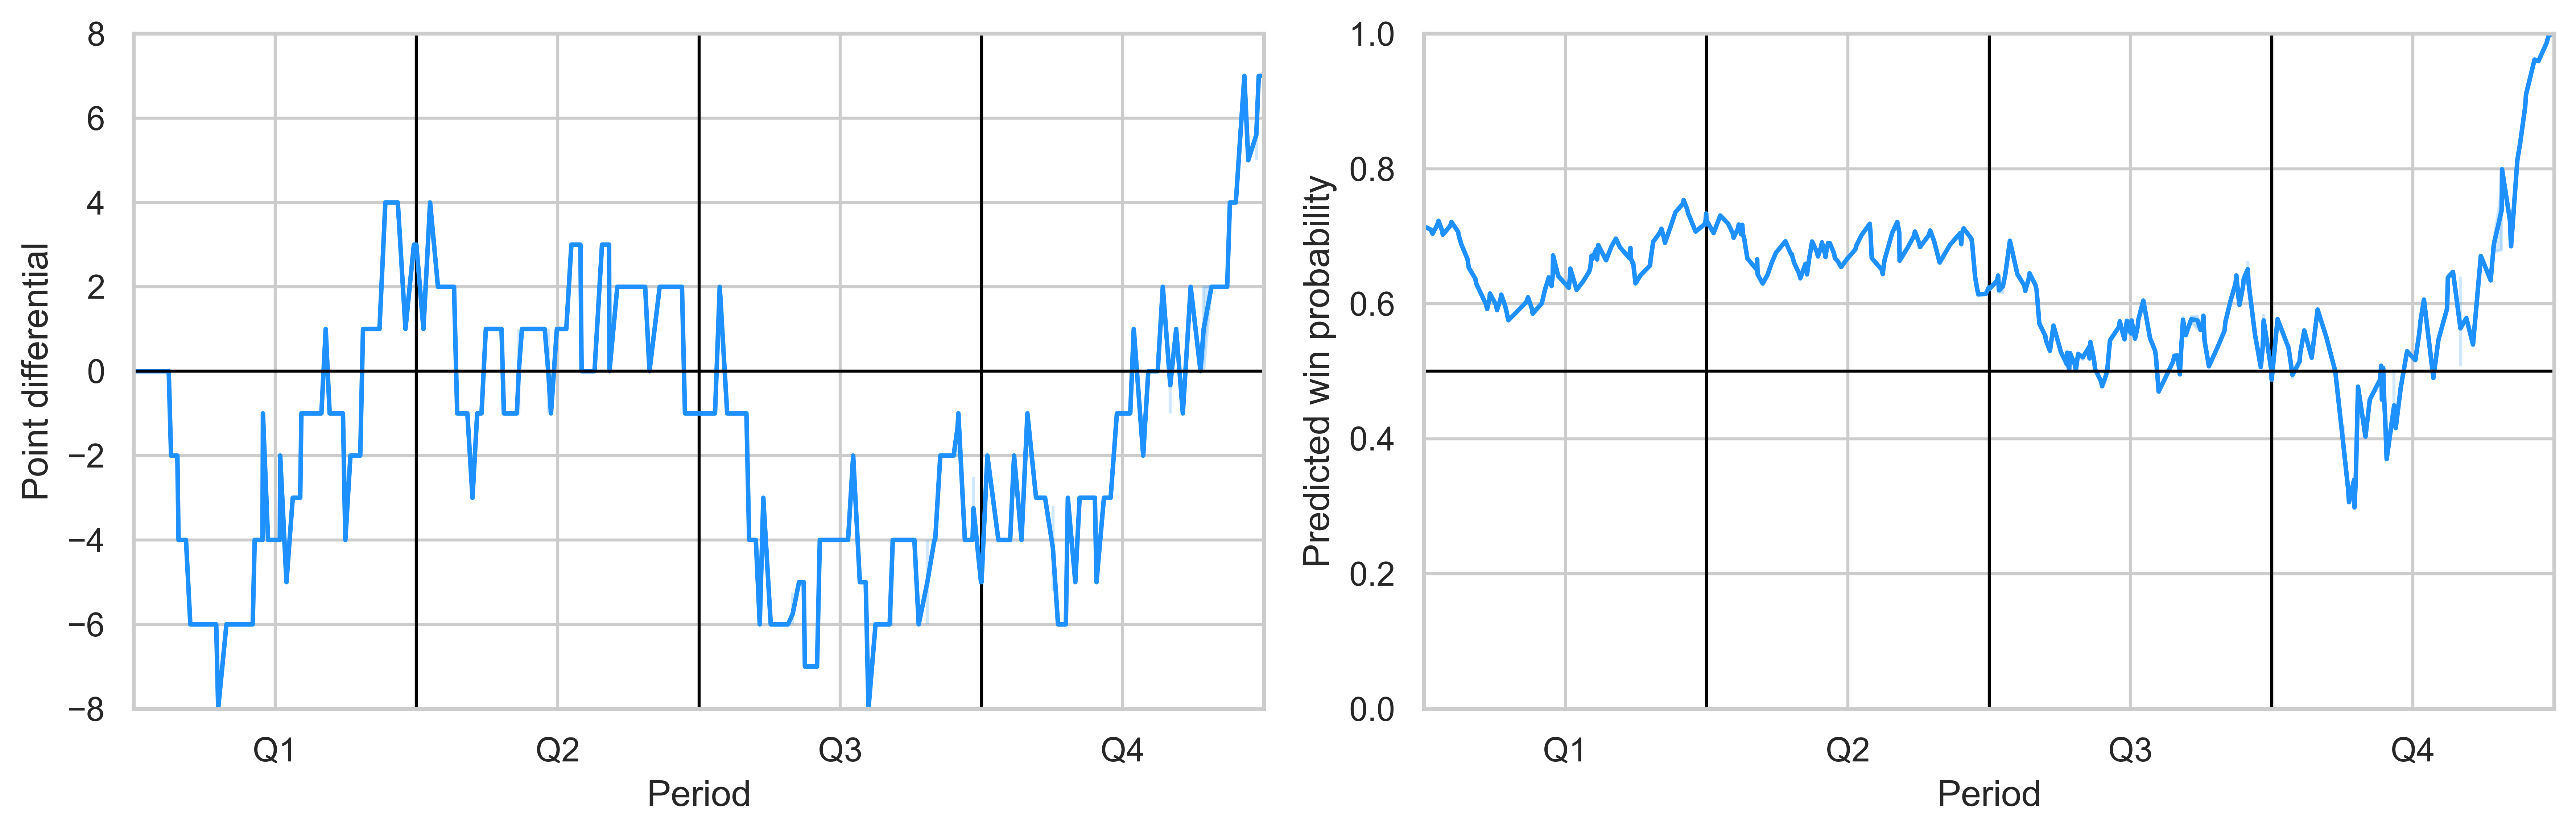

In [79]:
single_game_data = copy.deepcopy(data[data['game_id']==22100222])
single_game_X = scaler.transform(np.array(single_game_data[features[:-1]]))
single_game_data['win_probability_nn'] = model.predict(single_game_X)

# Create the figure and subplots with adjusted height
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, sharex=True, dpi=600)

# Add vertical lines to divide the plot into quarters
for i in range(1, 4):
    quarter_time = i * 720
    axes[0].axvline(x=quarter_time, color='black', linestyle='-', linewidth=1)
    axes[1].axvline(x=quarter_time, color='black', linestyle='-', linewidth=1)
    
# Plot the scoring margin (bottom plot with adjusted height)
sns.lineplot(x=2880 - single_game_data['time_left'], y=single_game_data['margin'], ax=axes[0], color='dodgerblue')
axes[0].set_xlim([0, 2880])
axes[0].set_ylim([-8, 8])
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_xlabel('Period')
axes[0].set_ylabel('Point differential')


# Plot the win probability
sns.lineplot(x=2880 - single_game_data['time_left'], y=single_game_data['win_probability_nn'], ax=axes[1], color='dodgerblue')
axes[1].set_xlim([0, 2880])
axes[1].set_ylim([0.0,1])
axes[1].axhline(y=0.5, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Period')
axes[1].set_ylabel('Predicted win probability')


# Set x-ticks to align with quarter lines
quarter_labels = ['Q1', 'Q2', 'Q3', 'Q4']
quarter_positions = [720/2, 1440-720/2, 2160-720/2, 2880-720/2]
axes[0].set_xticks(quarter_positions)
axes[0].set_xticklabels(quarter_labels)
axes[1].set_xticks(quarter_positions)
axes[1].set_xticklabels(quarter_labels)


plt.tight_layout()
plt.show()
fig.savefig('../figures/figure4.png')

12/12 [==============================] - 0s 849us/step


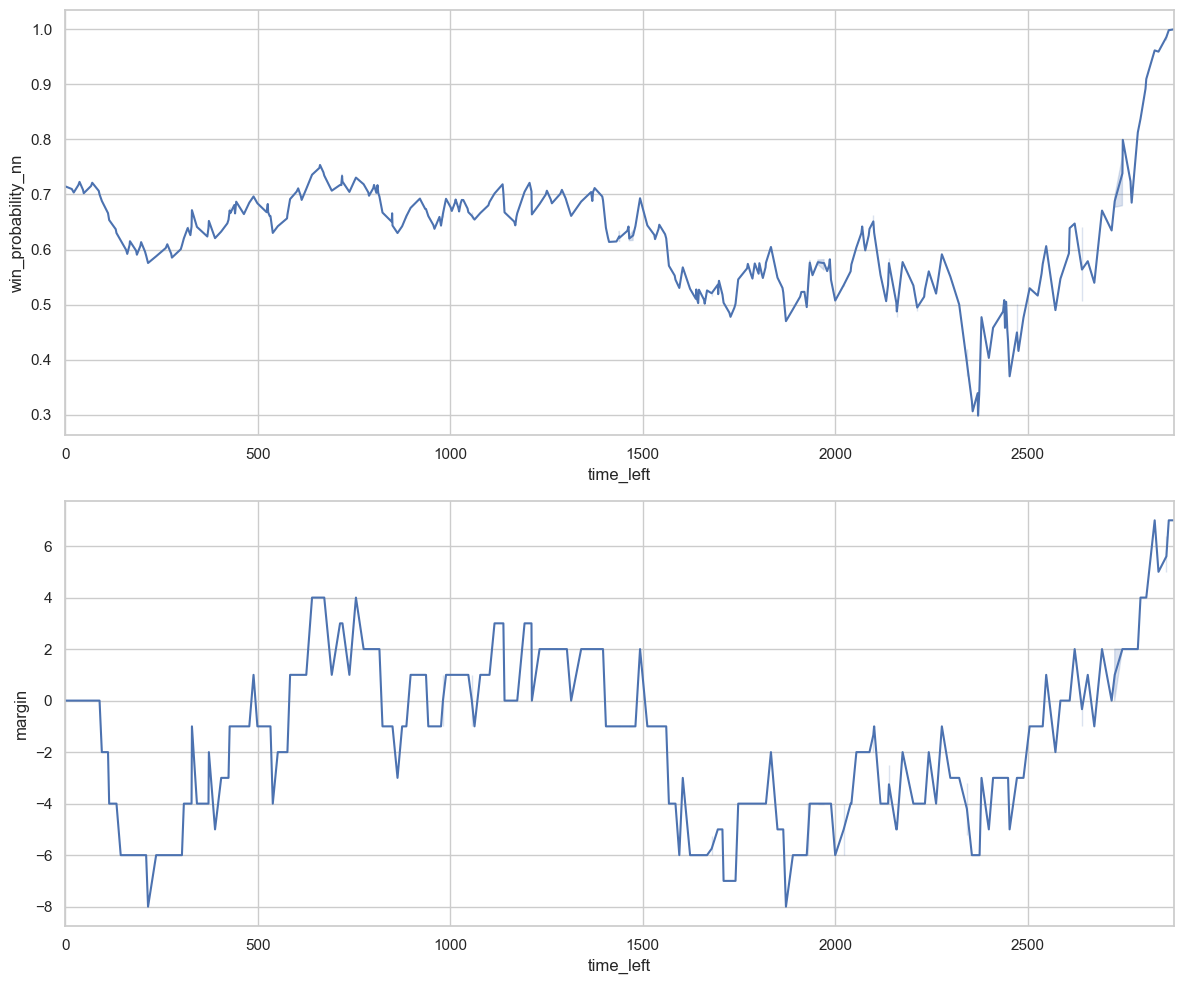

In [43]:

fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=1)
sns.lineplot(x=2880-single_game_data['time_left'], y=single_game_data['win_probability_nn'], ax=axes[0])
sns.lineplot(x=2880-single_game_data['time_left'], y=single_game_data['margin'], ax=axes[1])
axes[0].set_xlim([0,2880])
axes[1].set_xlim([0,2880])
plt.tight_layout()
plt.show()

In [176]:
game_ids = np.random.choice(test_game_ids, 1)
game_ids

array([21900759], dtype=int64)

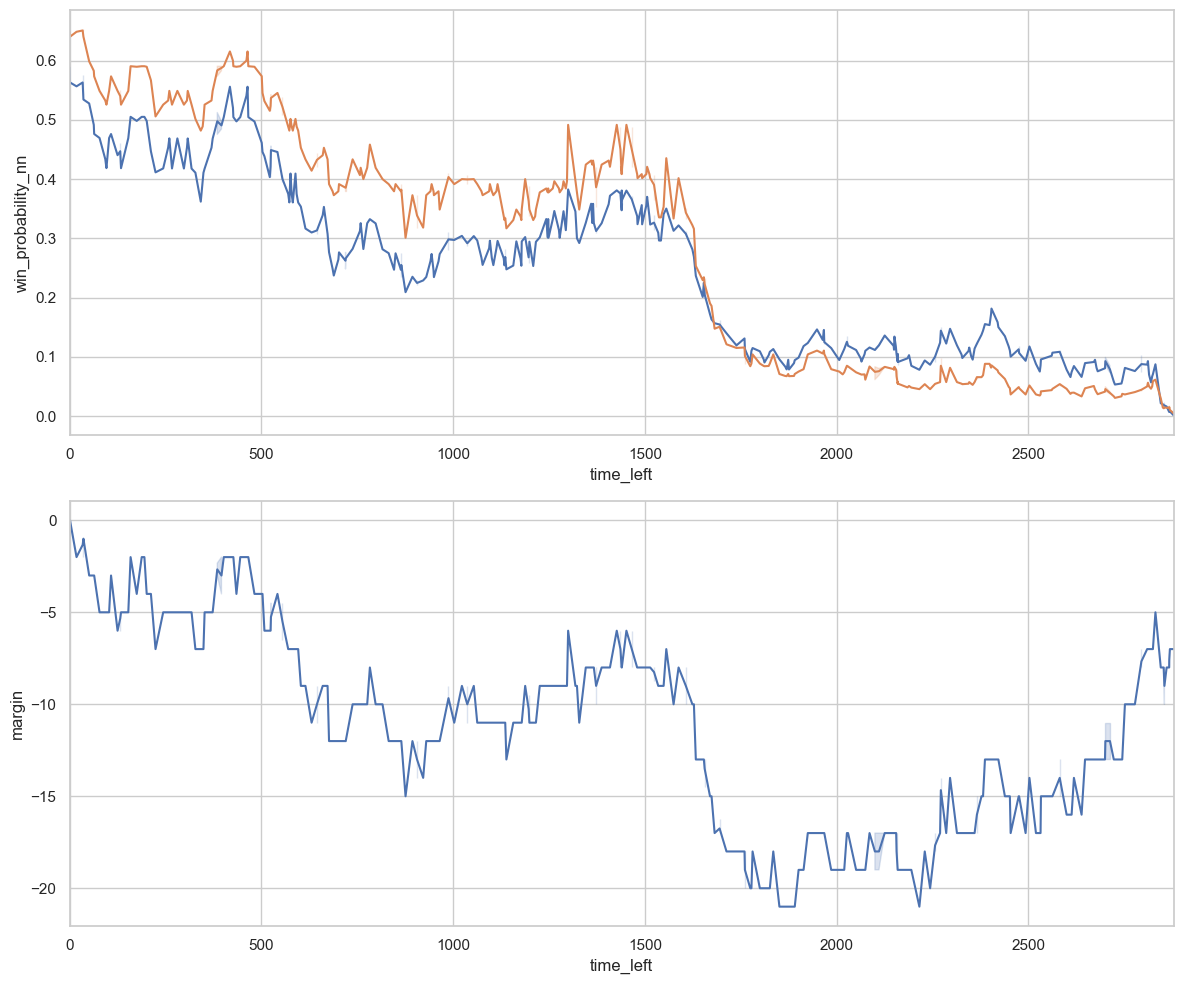

In [177]:
single_game_data = test_data[test_data['game_id']==game_ids[0]]
# single_game_data = single_game_data[single_game_data['time_left']<=300]
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=1)
sns.lineplot(x=2880-single_game_data['time_left'], y=single_game_data['win_probability_nn'], ax=axes[0])
sns.lineplot(x=2880-single_game_data['time_left'], y=single_game_data['win_probability_xgb'], ax=axes[0])
sns.lineplot(x=2880-single_game_data['time_left'], y=single_game_data['margin'], ax=axes[1])
axes[0].set_xlim([0,2880])
axes[1].set_xlim([0,2880])
plt.tight_layout()
plt.show()

In [ ]:
single_game_df = test_data[test_data['game_id']==game_id]
single_game_X = scaler.transform(np.array(single_game_df[features[:-1]]))
single_game_probs_nn = model.predict(single_game_X)
    single_game_probs_nn = single_game_probs_nn.reshape(single_game_probs_nn.shape[0],)

13/13 [==============================] - 0s 604us/step


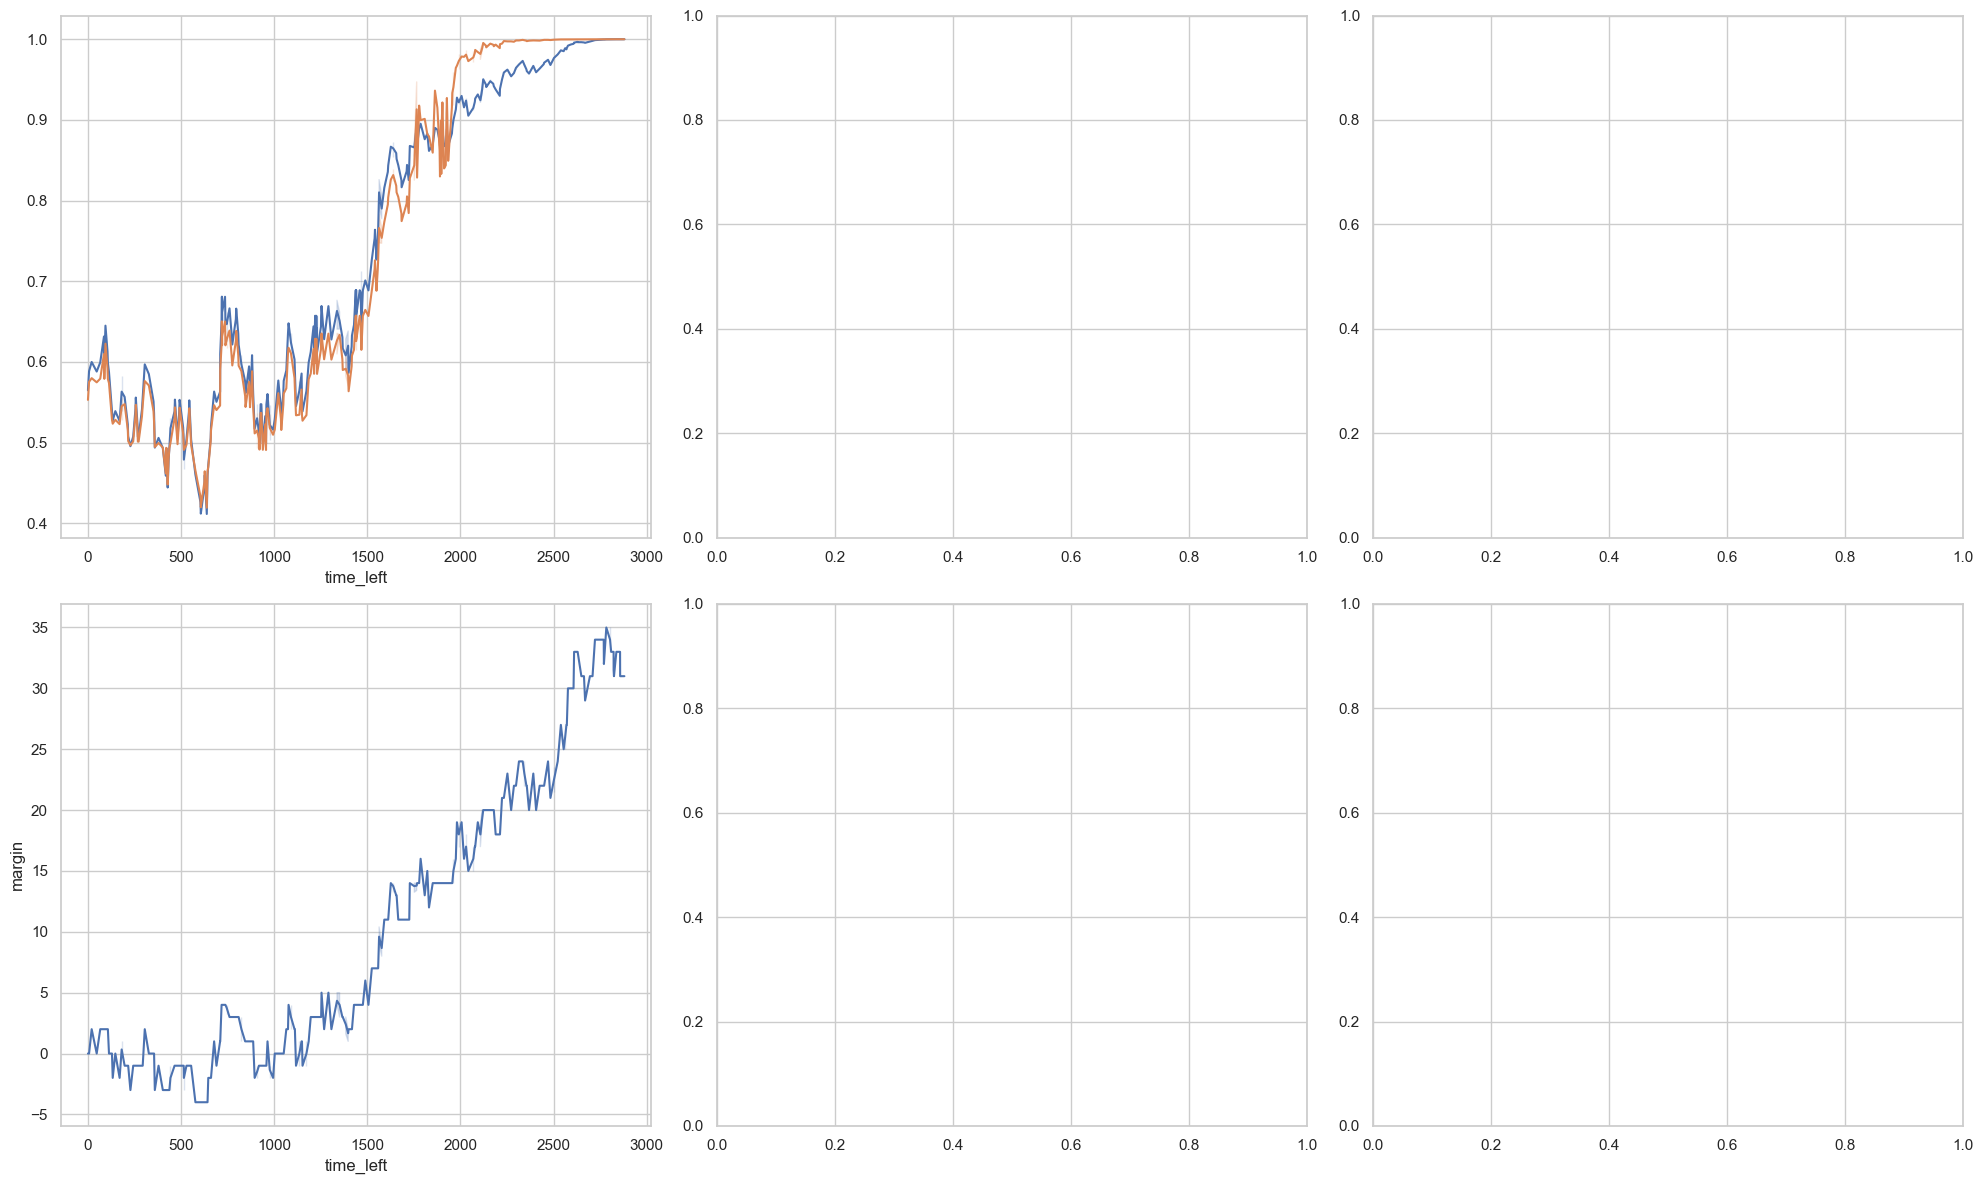

In [91]:
fig, axes = plt.subplots(figsize=(20,12), nrows=2, ncols=3)
for i, game_id in enumerate(game_ids):
    single_game_df = data[data['game_id']==game_id]
    single_game_X = scaler.transform(np.array(single_game_df[features[:-1]]))
    single_game_probs_lr = [prob[1] for prob in lr.predict_proba(single_game_X)]
    single_game_probs_nn = model.predict(single_game_X)
    single_game_probs_nn = single_game_probs_nn.reshape(single_game_probs_nn.shape[0],)
#     single_game_probs_xgb = [probs[1] for probs in xgbc.predict_proba(single_game_X)]
    sns.lineplot(x=2880-single_game_df['time_left'], y=single_game_probs_lr, ax=axes[0][i])
    sns.lineplot(x=2880-single_game_df['time_left'], y=single_game_probs_nn, ax=axes[0][i])
#     sns.lineplot(x=2880-single_game_df['time_left'], y=single_game_probs_xgb, ax=axes[0][i])
    sns.lineplot(x=2880-single_game_df['time_left'], y=single_game_df['margin'], ax=axes[1][i])
plt.tight_layout()
plt.show()   

In [98]:
def get_time_pressure(margin, time_left):
    x = margin / (time_left + 1)
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

sample_X = [[1, 0, 0, 0, 2880-t, 2, 0, get_time_pressure(5, 2880-t)] for t in range(2880)]
sample_X = np.array(sample_X)

lr_prediction = [probs[1] for probs in lr.predict_proba(sample_X)]
nn_prediction = model.predict(sample_X)
nn_prediction = nn_prediction.reshape(nn_prediction.shape[0],)

90/90 [==============================] - 0s 773us/step


In [76]:
def get_time_pressure(margin, time_left):
    x = margin / (time_left + 1)
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

sample_X = [[1, 0, 0, 0, 60, m, 0, get_time_pressure(m, 60)] for m in range(-30,30,1)]
sample_X = np.array(sample_X)

lr_prediction = [probs[1] for probs in lr.predict_proba(sample_X)]
nn_prediction = model.predict(sample_X)
nn_prediction = nn_prediction.reshape(nn_prediction.shape[0],)
xgb_prediction = [probs[1] for probs in xgbc.predict_proba(sample_X)]
# xgb_prediction = xgb_prediction.reshape(xgb_prediction.shape[0],)

2/2 [==============================] - 0s 4ms/step


<Axes: >

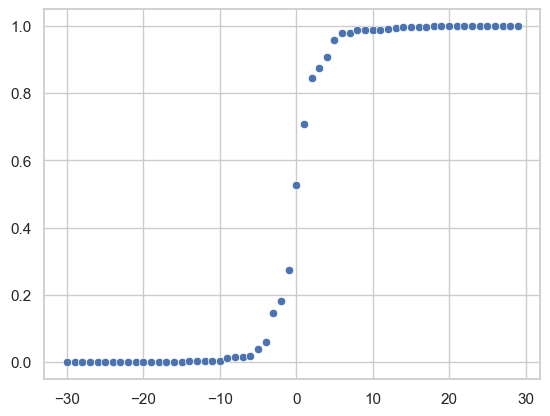

In [77]:
sns.scatterplot(x=[m for m in range(-30,30,1)], y=xgb_prediction)

In [ ]:
sns.scatterplot(x=[m for m in range(-30,30,1)], y=nn_prediction)